In [1]:
import sys, os, json, pickle, gzip, copy, torch, numbers, tqdm
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product

from src.utils import ActiveElements, MetalElements, Element, AllElements
from src.utils import composit_parser, linear_kld_annealing, parse_rxn_ids
from src.utils import heat_tempearture_norm, heat_tempearture_denorm, heat_time_norm, heat_time_denorm
#from src.utils import compute_metrics_from_cvae_output_v0
from src.feature import composition_to_feature
from src.trainer import VAETrainer, BaseTrainer

from pymatgen.core import Composition, Element

from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

# Multi-label

### compute_accuracy functions

In [113]:
def compute_accuracy_v1(th, output, norm_fn=None):
    label = np.vstack(output['label']).astype(bool)
    mask = np.vstack(output['label_mask'])
    pred = np.vstack(output['pred'])
    if norm_fn is not None:
        pred = norm_fn(pred)
    pred *= mask
    rxn_ids, is_last = parse_rxn_ids(output['rxn_id'])
    outs = {i:[[], []] for i in np.unique(rxn_ids)}
    for p_, l, m, i, s in zip(pred, label, mask, rxn_ids, is_last):
        p = p_ > th
        if not s and (p.sum() == 0):
            p[p_.argmax()] = True
        outs[i][0] = np.hstack([outs[i][0], p[l & m]])
        outs[i][1] = np.hstack([outs[i][1], l[p & m]])
    recall_prec = np.hstack([v[0] for v in outs.values()]).mean()
    precision_prec = np.hstack([v[1] for v in outs.values()]).mean()
    f1_prec = 2 * recall_prec * precision_prec / (precision_prec + recall_prec)
    recall_rxn = np.mean([np.sum(v[0] == 0) == 0 for v in outs.values()])
    precision_rxn = np.mean([np.sum(v[1] == 0) == 0 for v in outs.values()])
    f1_rxn = 2 * recall_rxn * precision_rxn / (precision_rxn + recall_rxn)
    return precision_prec, recall_prec, f1_prec, precision_rxn, recall_rxn, f1_rxn, 

def compute_accuracy_v2(output):
    label = np.vstack(output['label']).astype(bool)
    mask = np.vstack(output['label_mask'])
    pred_num = np.vstack(output['pred_num']).argmax(1)
    pred_lbl = np.vstack(output['pred_label']) * mask
    rxn_ids, is_last = parse_rxn_ids(output['rxn_id'])
    out = {f'top_n+{i}':{} for i in range(4)}
    acc_num = np.mean(pred_num == label.sum(1))
    for p, n, l, m, i, s in zip(pred_lbl, pred_num, label, mask, rxn_ids, is_last):
        if i not in out['top_n+0'].keys():
            for j in range(4):
                out[f'top_n+{j}'][i] = [[], []]
        if m.sum() == 1:
            for j in range(4):
                out[f'top_n+{j}'][i][0] = np.hstack([out[f'top_n+{j}'][i][0], [True]])
                out[f'top_n+{j}'][i][1] = np.hstack([out[f'top_n+{j}'][i][1], [True]])
        elif s and (n == 0) and l.sum() == 0:
            continue
        else:
            idxs = np.argsort(p)[::-1]
            if not s:
                n = np.max([1, n])
            for j in range(4):
                m1 = np.zeros_like(m)
                m1[idxs[:n+j]] = True
                out[f'top_n+{j}'][i][0] = np.hstack([out[f'top_n+{j}'][i][0], m1[l]])
                out[f'top_n+{j}'][i][1] = np.hstack([out[f'top_n+{j}'][i][1], l[m1]])
    _out = {}
    for k,vs in out.items():
        r = np.hstack([v[0] for v in vs.values()]).mean()
        p = np.hstack([v[1] for v in vs.values()]).mean()
        f = 2 * r * p / (r + p)
        r2 = np.mean([np.sum(v[0] == 0) == 0 for v in vs.values()])
        p2 = np.mean([np.sum(v[1] == 0) == 0 for v in vs.values()])
        f2 = 2 * r2 * p2 / (r2 + p2)
        _out[k] = [f, p, r, f2, p2, r2]
    return acc_num, _out

def compute_accuracy_v3(th, output, norm_fn=None):
    label = np.vstack(output['label']).astype(bool)
    mask1 = np.vstack(output['label_mask'])
    mask2 = np.vstack(output['label_mask_orig'])
    pred = np.vstack(output['pred'])
    if norm_fn is not None:
        pred = norm_fn(pred)
    pred *= mask1
    rxn_ids, is_last = parse_rxn_ids(output['rxn_id'])
    outs = []
    for i, (p_, l) in enumerate(zip(pred, label)):
        p = p_ > th
        m_ = rxn_ids == i
        for m in mask2[m_][:-1]:
            if p[m].sum() != 0:
                continue
            p[np.where(m)[0][p_[m].argmax()]] = True
        outs.append([p[l], l[p]])
    recall_prec = np.hstack([v[0] for v in outs]).mean()
    precision_prec = np.hstack([v[1] for v in outs]).mean()
    f1_prec = 2 * recall_prec * precision_prec / (precision_prec + recall_prec)
    recall_rxn = np.mean([np.sum(v[0] == 0) == 0 for v in outs])
    precision_rxn = np.mean([np.sum(v[1] == 0) == 0 for v in outs])
    f1_rxn = 2 * recall_rxn * precision_rxn / (precision_rxn + recall_rxn)
    return precision_prec, recall_prec, f1_prec, precision_rxn, recall_rxn, f1_rxn

def compute_accuracy_v4(output, norm_fn=None):
    label = np.vstack(output['label']).astype(bool)
    mask1 = np.vstack(output['label_mask'])
    mask2 = np.vstack(output['label_mask_orig'])
    pred_num = np.vstack(output['pred_num']).argmax(1)
    pred_lbl = np.vstack(output['pred_label'])
    if norm_fn is not None:
        pred = norm_fn(pred)
    acc_num = np.mean(pred_num == label.sum(1))
    rxn_ids, is_last = parse_rxn_ids(output['rxn_id'])
    out = {f'top_n+{i}':[] for i in range(5)}
    for i, (n, p_, l) in enumerate(zip(pred_num, pred_lbl, label)):
        idxs = np.argsort(p_)[::-1]
        p = np.zeros_like(l)
        for m in mask2[rxn_ids == i][:-1]:
            k = np.where(m)[0][np.argmax(p_[m])]
            p[k] = True
        m = mask1[i] & ~p
        ks = np.where(m)[0][np.argsort(p_[m])[::-1]]
        j = np.max([0, n - p.sum()])
        p[ks[:j]] = True
        out['top_n+0'].append([p[l], l[p]])
        for ii, k in enumerate(ks[j:j+4]):
            p[k] = True
            out[f'top_n+{ii+1}'].append([p[l], l[p]])
            
    _out = {}
    for k,vs in out.items():
        r = np.hstack([v[0] for v in vs]).mean()
        p = np.hstack([v[1] for v in vs]).mean()
        f = 2 * r * p / (r + p)
        r2 = np.mean([np.sum(v[0] == 0) == 0 for v in vs])
        p2 = np.mean([np.sum(v[1] == 0) == 0 for v in vs])
        f2 = 2 * r2 * p2 / (r2 + p2)
        _out[k] = [f, p, r, f2, p2, r2]
    return acc_num, _out

ths = np.linspace(0.1, 0.9, 81)

### data

In [114]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDSM = ReactionGraphDataset(feat_type='cgcnn')
GDSM.from_file('../data/screened_conditional_reaction.pkl.gz', 
               heat_temp_key=('heat_temp','median'))

DSM = ReactionDataset(feat_type='cgcnn')
DSM.from_file('../data/screened_conditional_reaction.pkl.gz', 
              heat_temp_key=('heat_temp','median'),
              )

# DS = ReactionDataset()
# DS.from_file('../data/screened_conditional_reaction.pkl.gz', 
#              heat_temp_key=('heat_temp','median'))

## Graph template - MSE

In [130]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = GraphCVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

#model = GraphConvolutionBlock(
#    input_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info,
#    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL, 
#    hidden_dim=128, hidden_layers=4,
#    batch_norm=False, dropout=0.5,
#)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.MSELoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                        #  output_keys=['pred','kld','mu','log_var','z']
                        output_keys=['pred','kld','mu','log_var','z']
#                         output_keys=['pred',]
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        # x = _feat['condition'].to('cuda')
        # edge_attr = _feat['edge_attr'].to('cuda')
        # edge_index = _feat['edge_index'].to('cuda')
        # pred = self.model(x=x, edge_attr=edge_attr, edge_index=edge_index)
        # output = [pred.detach()]

        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        # output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        mask = _feat['label_mask'].to('cuda')
        pred = torch.nn.functional.sigmoid(pred) * mask
        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')                
            mse_loss = self.crit(pred, label)[mask].mean() 
            loss = mse_loss + beta * kld.sum()
            return loss, output
            # alpha = (label[_feat['label_mask']] - 0.25).abs()
            # ce_loss = (self.crit(pred, feat['label']) * (feat['label_mask'] + 1e-4)).mean()
            # bce_loss = self.crit(pred, label)[_feat['label_mask']]
            # focal_loss = alpha * (1 - torch.exp(-bce_loss)) ** 2 * bce_loss
            # mse = torch.mean(torch.sum(torch.square(feat['x'] - pvec), -1))
            # loss = focal_loss + beta * kld.sum()
            # return loss.mean(), output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    if count > 20:
        break
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 ( 0) /   4.1366587  10.0729914   4.7807514 /     0.1248     0.1041
   1 ( 0) /   0.4696413   4.1042838   1.9131435 /     0.0508     0.0414
   2 ( 0) /   0.2276768   2.1618577   1.0098892 /     0.0267     0.0217
   3 ( 0) /   0.1385929   1.5623125   0.7269500 /     0.0192     0.0155
   4 ( 0) /   0.0958122   1.0511599   0.4958901 /     0.0129     0.0104
   5 ( 0) /   0.0735929   0.7968665   0.4040662 /     0.0097     0.0084
   6 ( 0) /   0.0617405   0.6706136   0.3394306 /     0.0082     0.0070
   7 ( 0) /   0.0511136   0.5179318   0.2567369 /     0.0063     0.0052
   8 ( 0) /   0.0448402   0.4763857   0.2440295 /     0.0058     0.0050
   9 ( 0) /   0.0394963   0.3625417   0.1875845 /     0.0043     0.0037
  10 ( 0) /   0.0361566   0.3063503   0.1638726 /     0.0037     0.0032
  11 ( 0) /   0.0317457   0.2540768   0.1386562 /     0.0030     0.0027
  12 ( 0) /   0.0296609   0.2798182   0.1555716 /     0.0033     0.0030
  13 ( 0) /   0.0275373   0.2194406   0.1205992 /     0.0026    

In [131]:
with open('../dump/multi_gr_mse.output.pkl','wb') as f:
    pickle.dump([best_valid_output, best_test_output], f)

In [ ]:
with open('../dump/multi_gr_mse.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)

In [126]:
ths = np.linspace(0.1, 0.9, 81)
p_p, r_p, f_p, p_r, r_r, f_r = np.array([compute_accuracy_v1(th, best_valid_output, lambda x: np.clip(x, 0, 1)) for th in ths]).T

In [127]:
for i in [np.argmax(f_p), np.argmax(f_r)]:
    for j in range(5):
        k = i - j * 10
        print('{:.3f} / {:.3f}  {:.3f}  {:.3f} / {:.3f}  {:.3f}  {:.3f}' .format(ths[k], f_p[k], p_p[k], r_p[k], f_r[k], p_r[k], r_r[k]))
    print()

0.590 / 0.888  0.891  0.884 / 0.701  0.715  0.687
0.490 / 0.887  0.887  0.888 / 0.700  0.702  0.698
0.390 / 0.886  0.880  0.893 / 0.699  0.687  0.711
0.290 / 0.883  0.867  0.899 / 0.691  0.663  0.723
0.190 / 0.875  0.845  0.907 / 0.679  0.624  0.743

0.570 / 0.888  0.890  0.885 / 0.701  0.713  0.689
0.470 / 0.887  0.885  0.889 / 0.700  0.700  0.700
0.370 / 0.886  0.878  0.894 / 0.699  0.684  0.713
0.270 / 0.881  0.863  0.900 / 0.689  0.656  0.724
0.170 / 0.872  0.837  0.909 / 0.673  0.612  0.748



## Graph template - BCE

In [808]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = GraphCVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.BCEWithLogitsLoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                         output_keys=['pred','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            label_mask = _feat['label_mask'].to('cuda')
            alpha = (label[label_mask] - 0.25).abs()
            bce_loss = self.crit(pred, label)[label_mask]
            focal_loss = alpha * (1 - torch.exp(-bce_loss)) ** 2 * bce_loss
            loss = focal_loss.mean() + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-3)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    if count > 20:
        break
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 ( 0) /   0.9872253   0.5534517   0.2839058 /     0.0068     0.0060
   1 ( 0) /   0.0285967   0.2475537   0.1293074 /     0.0030     0.0026
   2 ( 0) /   0.0188857   0.4286074   0.2485224 /     0.0053     0.0053
   3 ( 0) /   0.0148780   0.1376463   0.0812932 /     0.0016     0.0016
   4 ( 0) /   0.0132457   0.2763201   0.1610328 /     0.0034     0.0033
   5 ( 0) /   0.0115445   0.1138945   0.0681741 /     0.0013     0.0013
   6 ( 0) /   0.0103990   0.2415686   0.1445468 /     0.0029     0.0030
   7 ( 0) /   0.0098036   0.0979246   0.0615384 /     0.0011     0.0011
   8 ( 0) /   0.0084795   0.0774170   0.0508973 /     0.0009     0.0009
   9 ( 0) /   0.0073468   0.0741131   0.0483573 /     0.0008     0.0008
  10 ( 0) /   0.0069763   0.0519640   0.0355013 /     0.0006     0.0006
  11 ( 0) /   0.0067720   0.0491342   0.0347751 /     0.0005     0.0005
  12 ( 0) /   0.0061720   0.0450001   0.0331240 /     0.0005     0.0005
  13 ( 0) /   0.0063376   0.0349958   0.0266069 /     0.0003    

In [ ]:
with open('../dump/multi_gr_bce.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)

In [810]:
ths = np.linspace(0.1, 0.9, 81)
p_p, r_p, f_p, p_r, r_r, f_r = np.array([compute_accuracy_v1(th, best_valid_output, 
                                                             lambda x: 1/(1 + np.exp(-x))) for th in ths]).T


In [814]:
for i in [np.argmax(f_p), np.argmax(f_r)]:
    for j in range(5):
        k = i - j * 10
        print('{:.3f} / {:.3f}  {:.3f}  {:.3f} / {:.3f}  {:.3f}  {:.3f}' .format(ths[k], f_p[k], p_p[k], r_p[k], f_r[k], p_r[k], r_r[k]))
    print()

0.550 / 0.885  0.882  0.887 / 0.699  0.699  0.699
0.450 / 0.876  0.841  0.914 / 0.683  0.619  0.761
0.350 / 0.853  0.787  0.932 / 0.645  0.538  0.804
0.250 / 0.811  0.709  0.949 / 0.575  0.435  0.850
0.150 / 0.731  0.589  0.965 / 0.420  0.275  0.896

0.550 / 0.885  0.882  0.887 / 0.699  0.699  0.699
0.450 / 0.876  0.841  0.914 / 0.683  0.619  0.761
0.350 / 0.853  0.787  0.932 / 0.645  0.538  0.804
0.250 / 0.811  0.709  0.949 / 0.575  0.435  0.850
0.150 / 0.731  0.589  0.965 / 0.420  0.275  0.896



## Graphe template - CE

In [240]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = GraphCVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL + 5, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss()):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                         output_keys=['pred_num','pred_label','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')
        pred_num = pred[:, :5]
        pred_label = pred[:, 5:]

        output = [pred_num.detach(), pred_label.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            label_num = label.sum(1).long()
            loss_num = self.crit(pred_num, label_num)

            # _idx, _lbl = torch.where(label)
            # loss_label = self.crit(pred_label[_idx], _lbl)
            # loss = loss_num + loss_label + beta * kld.sum()

            pred_ = []
            label_  = []
            label_filter = mask.float() - 1
            for p, l, f in zip(pred_label, label, label_filter):
                idxs = torch.where(l)[0]
                f[idxs] = -1
                for i in idxs:
                    f[i] = 0
                    pred_.append(p + f * 1e5)
                    label_.append(i)
                    f[i] = -1
            loss_ce = self.crit(torch.vstack(pred_), torch.hstack(label_).long())
            loss = loss_num + loss_ce + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    if count > 20:
        break
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 ( 0) /   6.2453800  10.0808554   5.2049172 /     0.1150     0.0936
   1 ( 0) /   1.1329111   4.4747330   2.4961585 /     0.0483     0.0392
   2 ( 0) /   0.7604579   2.5952773   1.5843831 /     0.0260     0.0208
   3 ( 0) /   0.6180758   1.7527016   1.1777837 /     0.0160     0.0130
   4 ( 0) /   0.5459739   1.4013840   1.0094796 /     0.0120     0.0100
   5 ( 0) /   0.5013333   1.1575505   0.8842197 /     0.0091     0.0074
   6 ( 0) /   0.4718702   0.9813771   0.7917231 /     0.0071     0.0058
   7 ( 0) /   0.4495049   0.8338495   0.7233526 /     0.0054     0.0045
   8 ( 0) /   0.4332029   0.7898014   0.6882434 /     0.0050     0.0042
   9 ( 0) /   0.4192299   0.7328451   0.6716485 /     0.0042     0.0037
  10 ( 0) /   0.4074536   0.6655401   0.6414785 /     0.0035     0.0031
  11 ( 0) /   0.3969782   0.6419239   0.6340016 /     0.0032     0.0029
  12 ( 0) /   0.3888823   0.5906458   0.5999787 /     0.0027     0.0023
  13 ( 0) /   0.3808100   0.5676733   0.5888614 /     0.0024    

In [815]:
with open('../dump/multi_gr_ce.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)

In [431]:
acc_num, out = compute_accuracy_v2(best_valid_output)
for k,v in out.items():
    print(k, ' {:.3f}  {:.3f}  {:.3f} /  {:.3f}  {:.3f}  {:.3f}'.format(*v))

top_n+0  0.825  0.891  0.767 /  0.161  0.456  0.098
top_n+1  0.833  0.779  0.895 /  0.186  0.121  0.400
top_n+2  0.762  0.646  0.929 /  0.013  0.007  0.552
top_n+3  0.688  0.543  0.938 /  0.000  0.000  0.599


## non-graph MSE / precursor

In [133]:
years = np.array([d.year for d in DSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(DSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=DSM.cfn)
valid_dl = DataLoader(DSM, batch_size=2048, sampler=valid_idx, collate_fn=DSM.cfn)
test_dl = DataLoader(DSM, batch_size=2048, sampler=test_idx, collate_fn=DSM.cfn)

model = CVAE(
    input_dim=DSM.num_precursor_feat, latent_dim=16, 
    condition_dim=DSM.num_meta_feat + DSM.has_temp_info + DSM.has_time_info, 
    output_dim=DSM.NUM_LABEL, 
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.MSELoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','label_mask_orig','rxn_id'],
                         output_keys=['pred','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')
        pred = torch.nn.functional.sigmoid(pred) * mask
        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            loss_mse = self.crit(pred, label)[mask]

            loss = loss_mse.mean() + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

    if count > 20:
        break


   0 ( 0) /   1.4431578   4.3942835   2.1149255 /     0.2255     0.1883
   1 ( 0) /   0.2985735   1.6468765   0.7986455 /     0.0827     0.0678
   2 ( 0) /   0.1475267   0.7874559   0.4052470 /     0.0387     0.0331
   3 ( 0) /   0.0900553   0.4766293   0.2481531 /     0.0231     0.0196
   4 ( 0) /   0.0622465   0.3216004   0.1719969 /     0.0154     0.0132
   5 ( 0) /   0.0472525   0.2398162   0.1300363 /     0.0113     0.0097
   6 ( 0) /   0.0382148   0.1859985   0.1022007 /     0.0087     0.0073
   7 ( 0) /   0.0321171   0.1523525   0.0844345 /     0.0070     0.0058
   8 ( 0) /   0.0280721   0.1189076   0.0687122 /     0.0053     0.0044
   9 ( 0) /   0.0252833   0.1013700   0.0606392 /     0.0044     0.0037
  10 ( 0) /   0.0232446   0.0837222   0.0524306 /     0.0035     0.0030
  11 ( 0) /   0.0214729   0.0722268   0.0467077 /     0.0029     0.0025
  12 ( 0) /   0.0201810   0.0623484   0.0421406 /     0.0025     0.0021
  13 ( 0) /   0.0189987   0.0585595   0.0400101 /     0.0023    

In [118]:
with open('../dump/multi_ngr_mse.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)

In [136]:
ths = np.linspace(0.1, 0.9, 81)
p_p, r_p, f_p, p_r, r_r, f_r = np.array([compute_accuracy_v3(th, best_valid_output) for th in ths]).T

In [137]:
for i in [np.argmax(f_p), np.argmax(f_r)]:
    for j in range(5):
        k = i - j * 10
        print('{:.3f} / {:.3f}  {:.3f}  {:.3f} / {:.3f}  {:.3f}  {:.3f}' .format(ths[k], f_p[k], p_p[k], r_p[k], f_r[k], p_r[k], r_r[k]))
    print()

0.520 / 0.897  0.908  0.887 / 0.711  0.741  0.683
0.420 / 0.897  0.897  0.897 / 0.706  0.710  0.703
0.320 / 0.895  0.883  0.907 / 0.705  0.679  0.732
0.220 / 0.885  0.850  0.923 / 0.690  0.621  0.777
0.120 / 0.859  0.793  0.938 / 0.648  0.537  0.816

0.520 / 0.897  0.908  0.887 / 0.711  0.741  0.683
0.420 / 0.897  0.897  0.897 / 0.706  0.710  0.703
0.320 / 0.895  0.883  0.907 / 0.705  0.679  0.732
0.220 / 0.885  0.850  0.923 / 0.690  0.621  0.777
0.120 / 0.859  0.793  0.938 / 0.648  0.537  0.816



## non-graph / BCE / precursor

In [18]:
years = np.array([d.year for d in DSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(DSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=DSM.cfn)
valid_dl = DataLoader(DSM, batch_size=2048, sampler=valid_idx, collate_fn=DSM.cfn)
test_dl = DataLoader(DSM, batch_size=2048, sampler=test_idx, collate_fn=DSM.cfn)

model = CVAE(
    input_dim=DSM.num_precursor_feat, latent_dim=16, 
    condition_dim=DSM.num_meta_feat + DSM.has_temp_info + DSM.has_time_info, 
    output_dim=DSM.NUM_LABEL, 
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.BCEWithLogitsLoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','label_mask_orig','rxn_id'],
                         output_keys=['pred','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')

        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            loss_bce = self.crit(pred, label)[mask]

            loss = loss_bce.mean() + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

    if count > 20:
        break


   0 ( 0) /   2.3648114   6.3365924   3.4537435 /     0.3105     0.2839
   1 ( 0) /   0.6733154   2.2008216   1.2990386 /     0.0984     0.0918
   2 ( 0) /   0.3883096   1.1091099   0.7029022 /     0.0456     0.0432
   3 ( 0) /   0.2597759   0.7654274   0.4879319 /     0.0307     0.0284
   4 ( 0) /   0.1888618   0.5185855   0.3430914 /     0.0198     0.0183
   5 ( 0) /   0.1469847   0.3973866   0.2681041 /     0.0148     0.0135
   6 ( 0) /   0.1213814   0.3042930   0.2149611 /     0.0106     0.0097
   7 ( 0) /   0.1043803   0.2506023   0.1814435 /     0.0084     0.0077
   8 ( 0) /   0.0934226   0.2104324   0.1589120 /     0.0067     0.0060
   9 ( 0) /   0.0851591   0.1875649   0.1451196 /     0.0057     0.0052
  10 ( 0) /   0.0789724   0.1661060   0.1332142 /     0.0048     0.0043
  11 ( 0) /   0.0744868   0.1494727   0.1237341 /     0.0042     0.0037
  12 ( 0) /   0.0709113   0.1336262   0.1144212 /     0.0035     0.0031
  13 ( 0) /   0.0675319   0.1257083   0.1100486 /     0.0032    

In [12]:
with open('../dump/multi_ngr_bce.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)

In [59]:
ths = np.linspace(0.1, 0.9, 81)
p_p, r_p, f_p, p_r, r_r, f_r = np.array([compute_accuracy_v3(th, best_valid_output, lambda x: 1/(1 + np.exp(-x))) for th in ths]).T

In [60]:
for i in [np.argmax(f_p), np.argmax(f_r)]:
    for j in range(5):
        k = i - j * 10
        print('{:.3f} / {:.3f}  {:.3f}  {:.3f} / {:.3f}  {:.3f}  {:.3f}' .format(ths[k], f_p[k], p_p[k], r_p[k], f_r[k], p_r[k], r_r[k]))
    print()

0.460 / 0.900  0.908  0.892 / 0.715  0.740  0.693
0.360 / 0.898  0.895  0.902 / 0.711  0.702  0.720
0.260 / 0.891  0.866  0.918 / 0.702  0.652  0.762
0.160 / 0.872  0.817  0.935 / 0.675  0.581  0.805
0.870 / 0.895  0.912  0.878 / 0.703  0.752  0.661

0.460 / 0.900  0.908  0.892 / 0.715  0.740  0.693
0.360 / 0.898  0.895  0.902 / 0.711  0.702  0.720
0.260 / 0.891  0.866  0.918 / 0.702  0.652  0.762
0.160 / 0.872  0.817  0.935 / 0.675  0.581  0.805
0.870 / 0.895  0.912  0.878 / 0.703  0.752  0.661



## non-graph / CE / precursor

In [295]:
years = np.array([d.year for d in DSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(DSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=DSM.cfn)
valid_dl = DataLoader(DSM, batch_size=2048, sampler=valid_idx, collate_fn=DSM.cfn)
test_dl = DataLoader(DSM, batch_size=2048, sampler=test_idx, collate_fn=DSM.cfn)

model = CVAE(
    input_dim=DSM.num_precursor_feat, latent_dim=16, 
    condition_dim=DSM.num_meta_feat + DSM.has_temp_info + DSM.has_time_info, 
    output_dim=DSM.NUM_LABEL + 8, 
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss()):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','label_mask_orig','rxn_id'],
                         output_keys=['pred_num','pred_label','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')
        pred_num = pred[:, :8]
        pred_lbl = pred[:, 8:]

        output = [pred_num.detach(), pred_lbl.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            loss_num = self.crit(pred_num, label.sum(1).long())
            pred_ = []
            label_ = []
            label_filter = mask.float() - 1
            for p, l, f in zip(pred_lbl, label, label_filter):
                idxs = torch.where(l)[0]
                f[idxs] = -1
                for i in idxs:
                    f[i] =  0
                    pred_.append(p + f * 1e5)
                    label_.append(i)
                    f[i] = -1
            loss_ce = self.crit(torch.vstack(pred_), torch.hstack(label_).long())
            loss = loss_num + loss_ce + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1

    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

    if count > 20:
        break

   0 ( 0) /   6.6356480   9.6623845   7.0895848 /     0.2607     0.2297
   1 ( 0) /   4.2708760   5.4083018   4.5856606 /     0.0845     0.0762
   2 ( 0) /   3.2336525   3.9388611   3.5372292 /     0.0446     0.0396
   3 ( 0) /   2.6096034   3.1545638   3.0306039 /     0.0260     0.0224
   4 ( 0) /   2.2720163   2.7723464   2.7638831 /     0.0182     0.0155
   5 ( 0) /   2.0928228   2.5552930   2.6160775 /     0.0143     0.0120
   6 ( 0) /   1.9912406   2.3960652   2.5775914 /     0.0100     0.0085
   7 ( 0) /   1.9220033   2.2835037   2.5426366 /     0.0078     0.0068
   8 ( 0) /   1.8730984   2.2117662   2.4662166 /     0.0065     0.0055
   9 ( 0) /   1.8342673   2.1519496   2.4331937 /     0.0053     0.0046
  10 ( 0) /   1.8015133   2.1155270   2.4431750 /     0.0047     0.0040
  11 ( 0) /   1.7694851   2.0779146   2.4077092 /     0.0039     0.0034
  12 ( 0) /   1.7444689   2.0630885   2.3729048 /     0.0036     0.0031
  13 ( 0) /   1.7222991   2.0385060   2.3722790 /     0.0032    

In [251]:
with open('../dump/multi_ngr_ce.output.pkl','wb') as f:
    pickle.dump([best_valid_output, best_test_output], f)

In [455]:
with open('../dump/multi_ngr_ce.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)
acc_num, out = compute_accuracy_v4(best_valid_output)

In [435]:
for k,v in out.items():
    print(k, ' {:.3f}  {:.3f}  {:.3f} /  {:.3f}  {:.3f}  {:.3f}'.format(*v))

top_n+0  0.886  0.886  0.885 /  0.670  0.673  0.666
top_n+1  0.816  0.725  0.934 /  0.091  0.048  0.805
top_n+2  0.740  0.605  0.953 /  0.001  0.001  0.864
top_n+3  0.673  0.517  0.964 /  0.000  0.000  0.892
top_n+4  0.616  0.451  0.970 /  0.000  0.000  0.910


In [456]:
print(f'{acc_num*100:.3f}%')
for k,v in out.items():
    print(k, ' {:.3f}  {:.3f}  {:.3f} /  {:.3f}  {:.3f}  {:.3f}'.format(*v))

44.817%
top_n+0  0.887  0.887  0.886 /  0.673  0.674  0.672
top_n+1  0.816  0.725  0.933 /  0.093  0.049  0.806
top_n+2  0.738  0.603  0.951 /  0.005  0.002  0.856
top_n+3  0.672  0.516  0.963 /  0.000  0.000  0.889
top_n+4  0.616  0.451  0.971 /  0.000  0.000  0.912


In [362]:
np.where(p), np.where(l), [np.where(m)[0][np.argsort(p_[m])[::-1]] for m in mask2[rxn_ids == i][:-1]]

((array([], dtype=int64),),
 (array([10, 12, 66]),),
 [array([  4,  66, 115, 161, 203, 221, 176, 325, 242, 254, 348, 321, 112,
         268, 342, 218]),
  array([ 12,  87, 143, 117, 354,  41, 214]),
  array([ 10, 185,  81, 318,  64, 219])])

## non-graph / MSE / ligand

In [148]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = CVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    output_dim=GDSM.NUM_LABEL, 
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

#model = GraphConvolutionBlock(
#    input_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info,
#    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL, 
#    hidden_dim=128, hidden_layers=4,
#    batch_norm=False, dropout=0.5,
#)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.MSELoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                        #  output_keys=['pred','kld','mu','log_var','z']
                        output_keys=['pred','kld','mu','log_var','z']
#                         output_keys=['pred',]
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        # x = _feat['condition'].to('cuda')
        # edge_attr = _feat['edge_attr'].to('cuda')
        # edge_index = _feat['edge_index'].to('cuda')
        # pred = self.model(x=x, edge_attr=edge_attr, edge_index=edge_index)
        # output = [pred.detach()]

        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        # output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        mask = _feat['label_mask'].to('cuda')
        pred = torch.nn.functional.sigmoid(pred) * mask
        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')                
            mse_loss = self.crit(pred, label)[mask].mean() 
            loss = mse_loss + beta * kld.sum()
            return loss, output
            # alpha = (label[_feat['label_mask']] - 0.25).abs()
            # ce_loss = (self.crit(pred, feat['label']) * (feat['label_mask'] + 1e-4)).mean()
            # bce_loss = self.crit(pred, label)[_feat['label_mask']]
            # focal_loss = alpha * (1 - torch.exp(-bce_loss)) ** 2 * bce_loss
            # mse = torch.mean(torch.sum(torch.square(feat['x'] - pvec), -1))
            # loss = focal_loss + beta * kld.sum()
            # return loss.mean(), output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    if count > 20:
        break


   0 ( 0) /   4.3978746   7.1521318   3.5086499 /     0.0880     0.0754
   1 ( 0) /   0.4738037   2.4573934   1.2295869 /     0.0300     0.0260
   2 ( 0) /   0.2484359   1.3576525   0.6896678 /     0.0164     0.0143
   3 ( 0) /   0.1732227   0.9179142   0.4714379 /     0.0110     0.0096
   4 ( 0) /   0.1375738   0.6743139   0.3498023 /     0.0080     0.0070
   5 ( 0) /   0.1101557   0.5270885   0.2774339 /     0.0062     0.0054
   6 ( 0) /   0.0961178   0.4319286   0.2322158 /     0.0050     0.0045
   7 ( 0) /   0.0845738   0.3732274   0.1996891 /     0.0043     0.0038
   8 ( 0) /   0.0761226   0.3064854   0.1665254 /     0.0035     0.0030
   9 ( 0) /   0.0675144   0.2610174   0.1441435 /     0.0029     0.0026
  10 ( 0) /   0.0611745   0.2405825   0.1333810 /     0.0027     0.0023
  11 ( 0) /   0.0589667   0.2129328   0.1200549 /     0.0023     0.0020
  12 ( 0) /   0.0552858   0.1942853   0.1093941 /     0.0021     0.0018
  13 ( 0) /   0.0521522   0.1756267   0.1004825 /     0.0019    

In [149]:
with open('../dump/multi_ngr_ligand_mse.output.pkl','wb') as f:
    pickle.dump([best_valid_output, best_test_output], f)

In [150]:
with open('../dump/multi_ngr_ligand_mse.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)

In [151]:
ths = np.linspace(0.1, 0.9, 81)
p_p, r_p, f_p, p_r, r_r, f_r = np.array([compute_accuracy_v1(th, best_valid_output, lambda x: np.clip(x, 0, 1)) for th in ths]).T

In [152]:
for i in [np.argmax(f_p), np.argmax(f_r)]:
    for j in range(5):
        k = i - j * 10
        print('{:.3f} / {:.3f}  {:.3f}  {:.3f} / {:.3f}  {:.3f}  {:.3f}' .format(ths[k], f_p[k], p_p[k], r_p[k], f_r[k], p_r[k], r_r[k]))
    print()

0.400 / 0.802  0.801  0.803 / 0.558  0.563  0.553
0.300 / 0.797  0.771  0.825 / 0.556  0.524  0.592
0.200 / 0.781  0.725  0.847 / 0.511  0.429  0.631
0.100 / 0.734  0.622  0.897 / 0.404  0.279  0.733
0.810 / 0.795  0.808  0.781 / 0.550  0.584  0.519

0.380 / 0.801  0.795  0.806 / 0.559  0.557  0.560
0.280 / 0.796  0.765  0.830 / 0.554  0.513  0.601
0.180 / 0.776  0.711  0.853 / 0.498  0.405  0.646
0.890 / 0.791  0.807  0.775 / 0.546  0.584  0.512
0.790 / 0.795  0.809  0.783 / 0.550  0.584  0.520



## non-graph / BCE / ligand data

In [140]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = CVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    output_dim=GDSM.NUM_LABEL, 
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.BCEWithLogitsLoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id'],
                         output_keys=['pred','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')

        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            loss_bce = self.crit(pred, label)[mask]

            loss = loss_bce.mean() + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

    if count > 20:
        break


   0 ( 0) /   4.9697910   8.0490813   3.9666019 /     0.0964     0.0808
   1 ( 0) /   0.6698845   2.6875451   1.3599116 /     0.0310     0.0256
   2 ( 0) /   0.3746255   1.5087782   0.7938515 /     0.0168     0.0140
   3 ( 0) /   0.2735321   1.0383602   0.5627484 /     0.0112     0.0094
   4 ( 0) /   0.2171153   0.7848935   0.4361136 /     0.0082     0.0069
   5 ( 0) /   0.1849276   0.6158851   0.3558875 /     0.0062     0.0053
   6 ( 0) /   0.1670933   0.5457617   0.3197400 /     0.0054     0.0046
   7 ( 0) /   0.1514601   0.4397587   0.2692316 /     0.0041     0.0036
   8 ( 0) /   0.1396994   0.3907377   0.2429708 /     0.0036     0.0031
   9 ( 0) /   0.1314828   0.3425923   0.2205406 /     0.0030     0.0026
  10 ( 0) /   0.1236814   0.3161866   0.2064178 /     0.0027     0.0023
  11 ( 0) /   0.1194900   0.2937053   0.1955980 /     0.0025     0.0021
  12 ( 0) /   0.1135973   0.2640390   0.1819149 /     0.0021     0.0018
  13 ( 0) /   0.1095576   0.2446972   0.1735641 /     0.0019    

In [142]:
with open('../dump/multi_ngr_template_bce.output.pkl','wb') as f:
    pickle.dump([best_valid_output, best_test_output], f)

In [141]:
ths = np.linspace(0.1, 0.9, 81)
p_p, r_p, f_p, p_r, r_r, f_r = np.array(
    [compute_accuracy_v1(th, best_valid_output, lambda x: 1/(1 + np.exp(-x))) for th in ths]).T

for i in [np.argmax(f_p), np.argmax(f_r)]:
    for j in range(5):
        k = i - j * 10
        print('{:.3f} / {:.3f}  {:.3f}  {:.3f} / {:.3f}  {:.3f}  {:.3f}' .format(ths[k], f_p[k], p_p[k], r_p[k], f_r[k], p_r[k], r_r[k]))
    print()

0.400 / 0.800  0.797  0.804 / 0.554  0.556  0.553
0.300 / 0.795  0.766  0.826 / 0.550  0.514  0.591
0.200 / 0.776  0.712  0.852 / 0.492  0.398  0.644
0.100 / 0.733  0.619  0.898 / 0.381  0.258  0.733
0.810 / 0.792  0.807  0.777 / 0.544  0.581  0.511

0.380 / 0.800  0.791  0.808 / 0.555  0.548  0.561
0.280 / 0.795  0.761  0.831 / 0.551  0.508  0.602
0.180 / 0.770  0.698  0.859 / 0.485  0.384  0.659
0.890 / 0.790  0.807  0.773 / 0.543  0.581  0.509
0.790 / 0.792  0.807  0.778 / 0.544  0.581  0.512



## non-graph / CE / ligand

In [144]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = CVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    output_dim=GDSM.NUM_LABEL + 5, 
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss()):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id'],
                         output_keys=['pred_num','pred_label','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')
        pred_num = pred[:, :5]
        pred_lbl = pred[:, 5:]

        output = [pred_num.detach(), pred_lbl.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            loss_num = self.crit(pred_num, label.sum(1).long())
            pred_ = []
            label_ = []
            label_filter = mask.float() - 1
            for p, l, f in zip(pred_lbl, label, label_filter):
                idxs = torch.where(l)[0]
                f[idxs] = -1
                for i in idxs:
                    f[i] =  0
                    pred_.append(p + f * 1e5)
                    label_.append(i)
                    f[i] = -1
            loss_ce = self.crit(torch.vstack(pred_), torch.hstack(label_).long())
            loss = loss_num + loss_ce + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1

    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

    if count > 20:
        break

   0 ( 0) /   6.3632715   8.9387674   4.9062546 /     0.0921     0.0753
   1 ( 0) /   1.5846062   3.8159158   2.3708461 /     0.0337     0.0280
   2 ( 0) /   1.1282989   2.4360558   1.6508841 /     0.0186     0.0156
   3 ( 0) /   0.9555056   1.8488643   1.3613009 /     0.0123     0.0104
   4 ( 0) /   0.8709396   1.5519724   1.2030998 /     0.0091     0.0076
   5 ( 0) /   0.8219927   1.3669881   1.1150555 /     0.0071     0.0060
   6 ( 0) /   0.7879035   1.2365160   1.0472040 /     0.0057     0.0048
   7 ( 0) /   0.7648161   1.1342008   0.9917332 /     0.0046     0.0039
   8 ( 0) /   0.7483464   1.0980586   0.9754228 /     0.0042     0.0035
   9 ( 0) /   0.7338521   1.0231793   0.9393608 /     0.0035     0.0029
  10 ( 0) /   0.7257353   0.9937996   0.9206799 /     0.0031     0.0026
  11 ( 0) /   0.7167479   0.9568394   0.9110821 /     0.0026     0.0022
  12 ( 0) /   0.7074498   0.9254575   0.9049246 /     0.0023     0.0019
  13 ( 0) /   0.7012978   0.9138292   0.8860164 /     0.0022    

In [145]:
with open('../dump/multi_ngr_ligand_ce.output.pkl','wb') as f:
    pickle.dump([best_valid_output, best_test_output], f)
#    best_valid_output, best_test_output = pickle.load(f)

In [147]:
acc_num, out = compute_accuracy_v2(best_valid_output)
for k,v in out.items():
    print(k, ' {:.3f}  {:.3f}  {:.3f} /  {:.3f}  {:.3f}  {:.3f}'.format(*v))

top_n+0  0.800  0.803  0.796 /  0.561  0.569  0.552
top_n+1  0.610  0.459  0.908 /  0.000  0.000  0.738
top_n+2  0.470  0.314  0.932 /  0.000  0.000  0.800
top_n+3  0.382  0.239  0.945 /  0.000  0.000  0.838


# Single label

### accuracy calculator

### data

In [8]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock

GDSS = ReactionGraphDataset(feat_type='cgcnn',
               data_weight_fnc = None, #
#               data_weight_fnc = lambda x: 1/x['count'],
               label_weight_fnc = None,
#               label_weight_fnc=lambda x: 1/np.power(x['count'], 1.2),
)
GDSS.from_file('../data/screened_unique_reaction_ss.pkl.gz', 
               heat_temp_fnc = lambda x: x['heat_temp_med'],
               heat_time_fnc = lambda x: x['heat_time_med'],
               )

#DSS = ReactionDataset(feat_type='cgcnn')
#DSS.from_file('../data/screened_single_source_unique_reaction.pkl.gz')
#              heat_temp_key=('heat_temp','median'))


In [3]:
years = np.array([d.year for d in GDSS])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]
print(len(train_idx), len(valid_idx), len(test_idx))

train_dl = DataLoader(GDSS, batch_size=64, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSS.cfn)
feat, info = next(iter(train_dl))
feat['weight'].shape, feat['meta_feat'].shape, feat['condition_feat'].shape


16911 3230 1924


(torch.Size([267, 139]), torch.Size([267, 91]), torch.Size([64, 2]))

## Graphe template - CE

In [6]:
years = np.array([d.year for d in GDSS])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSS, batch_size=128, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSS.cfn)
valid_dl = DataLoader(GDSS, batch_size=2048, sampler=valid_idx, collate_fn=GDSS.cfn)
test_dl = DataLoader(GDSS, batch_size=2048, sampler=test_idx, collate_fn=GDSS.cfn)

model = GraphCVAE(
    input_dim=GDSS.num_precursor_feat, latent_dim=32, 
    condition_dim=GDSS.num_meta_feat + GDSS.has_temp_info + GDSS.has_time_info, 
    edge_dim=GDSS.num_edge_feat, output_dim=GDSS.NUM_LABEL + 1, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=6,
    decoder_hidden_dim=128, decoder_hidden_layers=6,
    batch_norm=True, dropout=0,
)

tr = VAETrainer(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(linear_kld_annealing(5000, start=1e-5, stop=1, ratio=0.5, period=50)):
    train_loss = tr.train(train_dl, beta=beta)
    valid_loss, valid_output = tr.test(valid_dl, beta=beta)
    test_loss, test_output = tr.test(test_dl, beta=beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, 
        np.vstack(valid_output['kld']).sum(), np.vstack(test_output['kld']).sum()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))
    if count > 40:
        break


   0 ( 0) /   1.0171463   1.0022747   1.1036375 / 135241.3750 75823.3828
   1 ( 0) /   3.2611367   4.5387368   4.6385427 /  1013.0734   514.3589
   2 ( 0) /   0.7844896   2.7852713   2.9534781 /   292.7118   153.7955
   3 ( 0) /   0.6571463   2.3615699   2.5313296 /   162.2264    85.5889
   4 ( 0) /   0.6034948   2.1026858   2.2241242 /   106.1408    54.7859
   5 ( 0) /   0.5687981   1.9083169   2.0151911 /    75.5524    38.9427
   6 ( 0) /   0.5411562   1.6162309   1.7419989 /    51.0875    27.1240
   7 ( 0) /   0.5169155   1.5030859   1.6532216 /    39.1931    21.4991
   8 ( 0) /   0.5040772   1.1309966   1.2441450 /    23.1892    12.3957
   9 ( 0) /   0.4889133   0.9813979   1.1181761 /    16.4588     9.3536
  10 ( 0) /   0.4790997   1.2440718   1.3805959 /    21.5553    11.7909
  11 ( 0) /   0.4696865   1.5505175   1.7074103 /    26.5123    14.4528
  12 ( 0) /   0.4605872   1.1695130   1.3236741 /    16.3714     9.1390
  13 ( 0) /   0.4505453   0.8714549   0.9719226 /     9.4096   

KeyboardInterrupt: 

In [206]:
with open('../dump/sing_gr_ce_a.output.pkl','rb') as f:
    best_valid_output, best_test_output = pickle.load(f)

In [4]:
acc_num, th, out = compute_metrics_from_cvae_output_v0(best_valid_output, print_result=True)
print()
_ = compute_metrics_from_cvae_output_v0(best_test_output, th, print_result=True)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3230 but corresponding boolean dimension is 14043

In [21]:
_, th, _ = compute_metrics_from_cvae_output_v0(best_valid_output, print_result=True)
print()
_ = compute_metrics_from_cvae_output_v0(best_test_output, th, print_result=True)

Null label hit accuracy : 0.9876 (th: 0.641)
--------------------------------------------------------
       | Precursor              | Reaction
       | F1      Prec    Recall | F1      Prec    Recall 
--------------------------------------------------------
top_1  | 0.8959  0.8959  0.8959 | 0.7266  0.7266  0.7266
top_2  | 0.6359  0.4773  0.9521 | 0.0000  0.0000  0.8573
top_3  | 0.4876  0.3257  0.9699 | 0.0000  0.0000  0.9093
top_4  | 0.4001  0.2514  0.9802 | 0.0000  0.0000  0.9409

Null label hit accuracy : 0.9797 (th: 0.641)
--------------------------------------------------------
       | Precursor              | Reaction
       | F1      Prec    Recall | F1      Prec    Recall 
--------------------------------------------------------
top_1  | 0.8870  0.8870  0.8870 | 0.7157  0.7157  0.7157
top_2  | 0.6287  0.4722  0.9402 | 0.0000  0.0000  0.8342
top_3  | 0.4836  0.3233  0.9595 | 0.0000  0.0000  0.8846
top_4  | 0.3993  0.2512  0.9730 | 0.0000  0.0000  0.9241


In [296]:
from sklearn.metrics import f1_score

recall_score([1,2,3,4],[1,1,3,4], average='micro')

0.75

In [281]:
from src.utils import parse_rxn_ids, sort_precursor_by_target_element

rxn_id, is_last = parse_rxn_ids(best_valid_output['rxn_id'])
pred_label = np.vstack(best_valid_output['pred_label'])
pred_has = np.hstack(best_valid_output['pred_has'])[is_last]
metals = np.hstack([o['metals'] for o in best_valid_output['info']])
targets = [o['target_comp'] for o in best_valid_output['info']]
likelies = []
for i, target in enumerate(targets):
    m = rxn_id == i
    comps = list(target.keys())
    ele_mask = [GDSS.precursor_dataset.get_weight(e).reshape(-1) > 0 for e in target.keys() if e not in MetalElements]
    sorted_probs = []
    for metal, prob in zip(metals[m], pred_label[m]):
        step_probs = []
        idxs = np.argsort(prob)[::-1]
        p_sum = 0
        for idx in idxs:
            p = prob[idx]
            if p_sum > 0.99 or p < 0.01:
                break
            p_sum += p
            step_probs.append([p, idx])
        if metal == 'none':
            step_probs = [[1 - pred_has[i], GDSS.precursor_dataset._ligand_str.index('')]] + [[_p * pred_has[i], _i] for _p,_i in step_probs]
        sorted_probs.append(step_probs)

    if 'Se' in target.keys() and pred_has[i] < 0.5:
        break

    for comb in product(*sorted_probs):
        l = np.prod([c[0] for c in comb])
        if np.sum([c[0] for c in comb]) < 0.1:
            continue
        labels = [c[1] for c in comb]
        pass_combination = False
        if len(ele_mask) != 0:
            label_mask = np.zeros_like(ele_mask[0], dtype=bool)
            label_mask[labels] = True
            for _mask in ele_mask:
                if (_mask & label_mask).sum() == 0:
                    pass_combination = True
                    break
        if pass_combination:
            continue
#    likelies.append(likely)
#    likelies.append(np.sum([l[0] for l in likely]))

In [282]:
likely = []
for comb in product(*sorted_probs):
    labels = [c[1] for c in comb]
    label_mask = np.zeros_like(ele_mask[0], dtype=bool)
    label_mask[labels] = True
    pass_combination = False
    for _mask in ele_mask:
        if (_mask & label_mask).sum() == 0:
            pass_combination = True
            break
#    print(pass_combination, labels)
    l = np.prod([c[0] for c in comb])
    if pass_combination:
        print(l)
        continue
    p = []
    for metal, label in zip(metals[m], labels):
        if metal == 'none' and label == GDSS.precursor_dataset._ligand_str.index(''):
            continue
        p_comp = GDSS.precursor_dataset.get_info(metal, label)['precursor_comp']
        p.append(Composition(p_comp).get_integer_formula_and_factor()[0])
    likely.append([l, ' '.join(p), ' '.join([f'{c[0]:.4f}' for c in comb])])

    

0.036670297819938066
0.0026826445687233194
0.0011372890360462668
0.007775260124882419
0.0005688052888702186
0.00024114115832537947
0.0048528503792812155
0.00035501409824185715
0.00015050582782364806
0.0035657434179203373
0.0002608547729967979
0.00011058761819900021
0.012051080725239232
0.0008816063183766066
0.0003737510409274941
0.002555209338216658
0.0001869283551166316
7.924701292108977e-05
0.0015948082002330607
0.0001166694521413041
4.9461225802632505e-05
0.0011718220011696923
8.572556302608385e-05
3.634277312586979e-05
0.007960890237303491
0.0005823852062006726
0.000246898272506812
0.0016879599048965704
0.0001234840385897134
5.235022367559847e-05
0.0010535231919089885
7.707132030059625e-05
3.267386540632637e-05
0.0007741003932893375
5.6629925011820744e-05
2.4007874013185572e-05
0.007044721433329242
0.0005153621545177122
0.00021848430267641113
0.0014937032123499094
0.00010927303698407289
4.632556558046274e-05
0.0009322798316918621
6.820166662673394e-05
2.8913635670930708e-05
0.00068

In [283]:
best_valid_output['info'][i]['precursor_comps']

[{'Ge': 1.0}, {'Cd': 1.0}, {'Li': 1.0}, {'Se': 1.0}]

In [287]:
pred_has[i], target

(0.0151218, {'Li': 0.25, 'Cd': 0.125, 'Ge': 0.125, 'Se': 0.5})

In [284]:
target, np.sum([l[0] for l in likely if l[0] > 0.001]), sorted(likely, key=lambda x: x[0], reverse=True)

({'Li': 0.25, 'Cd': 0.125, 'Ge': 0.125, 'Se': 0.5},
 0.8296818144898724,
 [[0.23975483284913796, 'Li CdSe Ge', '0.5039 0.8066 0.5990 0.9849'],
  [0.13553697920068794, 'Li CdSe GeSe2', '0.5039 0.8066 0.3386 0.9849'],
  [0.0787914202147617, 'Li2CO3 CdSe Ge', '0.1656 0.8066 0.5990 0.9849'],
  [0.052049261163547765, 'Li3N CdSe Ge', '0.1094 0.8066 0.5990 0.9849'],
  [0.04605923895164712, 'Li2S CdSe Ge', '0.0968 0.8066 0.5990 0.9849'],
  [0.04454196378831918, 'Li2CO3 CdSe GeSe2', '0.1656 0.8066 0.3386 0.9849'],
  [0.030646150632995896, 'LiCl CdSe Ge', '0.0644 0.8066 0.5990 0.9849'],
  [0.029424222835891474, 'Li3N CdSe GeSe2', '0.1094 0.8066 0.3386 0.9849'],
  [0.026037974032069058, 'Li2S CdSe GeSe2', '0.0968 0.8066 0.3386 0.9849'],
  [0.02073026572119774, 'Li Cd GeSe2', '0.5039 0.1234 0.3386 0.9849'],
  [0.017539453956062618, 'Li CdSe GeS2', '0.5039 0.8066 0.0438 0.9849'],
  [0.01732472556054442, 'LiCl CdSe GeSe2', '0.0644 0.8066 0.3386 0.9849'],
  [0.011317388593757033, 'LiF CdSe Ge', '0.02

In [2]:
with gzip.open('../data/unique_reaction_ss.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)
composit_vec = np.vstack([composition_to_feature(rxn['target_comp']) for rxn in unique_reaction])
element_vec = composit_vec > 0
to_ids = [rxn['id_reaction'] for rxn in unique_reaction]
to_idx = {rxn['id_reaction']:i for i,rxn in enumerate(unique_reaction)}

In [3]:
network = {}

for i, (cv, ev) in enumerate(zip(composit_vec, element_vec)):
    m = (element_vec != ev).sum(1) == 0
    js = np.where(m)[0]
    d = np.square(cv - composit_vec[m]).sum(1)
    if ((d == 0).sum() > 1) and i > js[d == 0][0]:
        network[to_ids[i]] = to_ids[js[d == 0][0]]
        continue
    network[to_ids[i]] = {'id_reaction':[to_ids[j] for j in js], 'dist':d}

# with open('../data/info_target_distribution.pkl','wb') as f:
#     pickle.dump(network, f)

In [16]:
from src.utils import sort_precursor_by_target_element

def get_neighbors(id):
    out = network[id]
    if isinstance(out, int):
        return get_neighbors(out)
    else:
        return out
    
nbrs = get_neighbors(793)
for rxn_id, dist in sorted(zip(nbrs['id_reaction'], nbrs['dist']), key=lambda x: x[1]):
    if rxn_id not in to_idx.keys():
        continue
    nbr = unique_reaction[to_idx[rxn_id]]
    target, precursor = sort_precursor_by_target_element(nbr['target_comp'], nbr['precursor_comp'])
    print(f'{rxn_id}\t{dist:.8f}    {target:15s}\t', precursor)

789	0.00000000    SrFe12O19      	 ['SrCO3', 'Fe2O3']
790	0.00000000    SrFe12O19      	 ['SrCO3', 'Fe2CO3']
791	0.00000000    SrFe12O19      	 ['Sr(CO2)2', 'Fe(CO2)2', 'H6C2O']
792	0.00000000    SrFe12O19      	 ['Sr(HO)2', 'Fe2O3']
793	0.00000000    SrFe12O19      	 ['Sr(NO3)2', 'Fe2O3']
794	0.00000000    SrFe12O19      	 ['SrO', 'Fe2O3']
7529	0.00000397    Sr10Fe114O181  	 ['SrCO3', 'Fe2O3']
23906	0.00011923    Sr5Fe58O95     	 ['SrCO3', 'Fe2O3']
20615	0.00018749    Sr2Fe23O38     	 ['SrCO3', 'Fe2O3']
20614	0.00077434    SrFe11O19      	 ['SrCO3', 'Fe2O3']
4869	0.00159893    SrFe1000O1501  	 ['SrCO3', 'Fe2O3']
20613	0.00179985    Sr2Fe21O38     	 ['SrCO3', 'Fe2O3']
20612	0.00330729    SrFe10O19      	 ['SrCO3', 'Fe2O3']
20611	0.00534430    Sr2(FeO2)19    	 ['SrCO3', 'Fe2O3']
1028	0.03419261    Sr4Fe6O13      	 ['SrCO3', 'Fe2O3']
88	0.05914063    SrFeO3         	 ['SrCO3', 'Fe2O3']
89	0.05914063    SrFeO3         	 ['SrCO3', 'Fe(CO2)2']
90	0.05914063    SrFeO3         	 ['SrO2', 'Fe'

In [7]:
with open('../data/info_target_distribution.pkl','rb') as f:
    network = pickle.load(f)

In [12]:
feat, info = GDSS.cfn([GDSS[0]])
info = info[0]

In [75]:
def parse_sampled_output(target, heat_temps=None, heat_times=None, 
                         n_sample=1000, th=0.4, *args, **kwargs):
    DS = ReactionGraphDataset(*args, **kwargs)
    DS.from_dataset(dataset = dataset, target_comp_key='target_comp', extend_dataset=True, *args, **kwargs)
    feat, _info = DS.cfn(DS)

    condition = torch.hstack([feat['meta_feat'], feat['condition_feat'][feat['rxn_id']]]).to('cuda')
    edge_attr = feat['edge_attr'].cuda()
    edge_index = feat['edge_index'].cuda()
    mask = (~(feat['weight'] > 0)).float() * (-5000)
    with torch.no_grad():
        sampling_output = model.sampling(n=n_sample, edge_index=edge_index, edge_attr=edge_attr, 
                                         condition=condition)
    sampling_output = torch.stack(sampling_output).transpose(1,0)

    summary_set = []
    likelihood_set = []
    target_set = []
    condition.T
    for i, info in enumerate(_info):
        target_set.append(Composition(info['target_comp']).get_integer_formula_and_factor()[0])

        metals = [e for e in info['target_comp'].keys() if e in MetalElements] + ['None']
        summary = {m:{} for m in metals}
        likelihood = {}
        w = mask[feat['rxn_id'] == i]
        for out in sampling_output[feat['rxn_id'] == i].transpose(0,1):
            probs = torch.nn.functional.softmax(out[:, 1:].cpu() + w, dim=1).numpy()
            has_last = 1/(1 + np.exp(-out[-1,0].item()))
            sorted_probs = []
            for m, prob in zip(metals, probs):
                p_sum = 0
                idxs = np.argsort(prob)[::-1]
                step_probs = []
                for j, idx in enumerate(idxs):
                    if p_sum > 0.999 or prob[idx] < 0.001:
                        break
                    p_sum += prob[idx]
        #            print(m, j, idx, prob[idx])
                    precursor_comp = GDSS.precursor_dataset.get_info(m, idx)['precursor_comp']
                    pstr = Composition(precursor_comp).get_integer_formula_and_factor()[0]
                    if m == 'None' and has_last < th:
                        continue
                    if pstr not in summary[m].keys():
                        summary[m][pstr] = 0
                    summary[m][pstr] += prob[idx] / n_sample
                    step_probs.append((prob[idx], pstr))
                if len(step_probs) != 0:
                    sorted_probs.append(step_probs)

            for comb in product(*sorted_probs):
                l = np.prod([c[0] for c in comb])
                k = tuple([c[1] for c in comb])
                if k not in likelihood.keys():
                    likelihood[k] = 0
                likelihood[k] += l / n_sample
        likelihood = {k: v for k,v in sorted(likelihood.items(), key=lambda x: x[1], reverse=True) if v > 0.005}
        summary_set.append(summary)
        likelihood_set.append(likelihood)
    return summary_set, likelihood_set

In [114]:
test_data = []
for i in range(11):
    dummy = _info[0].copy()
    dummy['heat_temp'] += 100 * (i-5)
    test_data.append(dummy)



In [66]:
i = 15517
th = 0.641
n_sample = 1000

feat, info = GDSS.cfn([GDSS[i]])
info = info[0]
#meta_feat = feat['meta_feat']
condition = torch.hstack([feat['meta_feat'], feat['condition_feat'][feat['rxn_id']]]).to('cuda')
edge_attr = feat['edge_attr'].cuda()
edge_index = feat['edge_index'].cuda()
mask = (~(feat['weight'] > 0)).float() * (-5000)
with torch.no_grad():
    sampling_output = model.sampling(n=n_sample, edge_index=edge_index, edge_attr=edge_attr, condition=condition)
metals = info['metals']
summary = {m:{} for m in metals}
likelihood = {}
for out in sampling_output:
    probs = torch.nn.functional.softmax(out[:, 1:].cpu() + mask, dim=1).numpy()
    has_last = 1/(1 + np.exp(-out[-1,0].item()))
    tree = {}
    sorted_probs = []
    for m, prob in zip(metals, probs):
        p_sum = 0
        idxs = np.argsort(prob)[::-1]
        step_probs = []
        for j, idx in enumerate(idxs):
            if p_sum > 0.999 or prob[idx] < 0.001:
                break
            p_sum += prob[idx]
#            print(m, j, idx, prob[idx])
            precursor_comp = GDSS.precursor_dataset.get_info(m, idx)['precursor_comp']
            pstr = Composition(precursor_comp).get_integer_formula_and_factor()[0]
            if m == 'none' and has_last < th:
                continue
            if pstr not in summary[m].keys():
                summary[m][pstr] = 0
            summary[m][pstr] += prob[idx] / n_sample
            step_probs.append((prob[idx], pstr))
        if len(step_probs) != 0:
            sorted_probs.append(step_probs)

    for comb in product(*sorted_probs):
        l = np.prod([c[0] for c in comb])
        k = tuple([c[1] for c in comb])
        if k not in likelihood.keys():
            likelihood[k] = 0
        likelihood[k] += l / n_sample
likelihood = {k: v for k,v in sorted(likelihood.items(), key=lambda x: x[1], reverse=True) if v > 0.005}


In [ ]:
TDS = ReactionGraphDataset(feat_type='cgcnn')
TDS.from_data({})

In [71]:
sampling_output[0].shape

torch.Size([3, 140])

In [81]:
def test_fnc(output, precursor_reference, 
             th=None, ths=np.linspace(0.1, 0.9, 81), 
             n_top=4, print_result=False):
    pred_has = np.hstack(output['pred_has'])
    pred_lbl = np.vstack(output['pred_label'])
    label = np.vstack(output['label'])
    weight = np.vstack(output['weight'])
    label_mask = weight > 0
    rxn_ids, is_last = parse_rxn_ids(output['rxn_id'])
    has_label = label.sum(1)[is_last]
    if th is None:
        has_hit = [np.mean(has_label == (pred_has[is_last] > th)) for th in ths]
        th = ths[np.argmax(has_hit)]

    acc = np.mean(has_label == (pred_has[is_last] > th))
    has_label = np.ones_like(is_last)
    has_label[is_last] = pred_has[is_last] > th

    parsed_output = {
        'info': output['info'],
        'th': th,
        'rxn_id':rxn_ids,
        'pred_has':pred_has,
        'pred_prec': pred_lbl,
        'label_prec': label,
        'weight': weight,
    }

    top_output = {f'top_{i+1}':{} for i in range(n_top)}
    for i, info in enumerate(output['info']):
        target = info['target_comp']
        m = rxn_ids == i
        nonmetal_mask = np.zeros(pred_lbl.shape[1], dtype=bool)
        for e in target.keys():
            if e in MetalElements:
                continue
            nonmetal_mask = nonmetal_mask | precursor_reference._nonmetal_mask[e]





test_fnc(best_valid_output, GDSS.precursor_dataset)

AttributeError: 'LigandTemplateReference' object has no attribute '_nonmetal_mask'

In [67]:
i, info, likelihood

(15517,
 {'id': 22034,
  'count': 1,
  'year': 2017,
  'data_type': 'basic',
  'feat_type': 'cgcnn',
  'target_comp': {'Ca': 0.25, 'Fe': 0.25, 'Se': 0.25, 'O': 0.25},
  'metals': array(['Ca', 'Fe', 'none'], dtype='<U4'),
  'precursor_comps': [{'Fe': 1.0}, {'Ca': 0.5, 'O': 0.5}, {'Se': 1.0}],
  'heat_temp': 1113.15,
  'heat_time': 10.0},
 {('Ca', 'Fe', 'Se'): 0.2932306326925755,
  ('CaCO3', 'Fe', 'Se'): 0.18888054078072283,
  ('CaO', 'Fe', 'Se'): 0.10081458969414228,
  ('Ca', 'Fe2O3', 'Se'): 0.048142668608575995,
  ('CaCO3', 'Fe2O3', 'Se'): 0.032151638914830964,
  ('Ca(NO3)2', 'Fe', 'Se'): 0.022340358433313695,
  ('CaO', 'Fe2O3', 'Se'): 0.017104164759162824,
  ('Ca', 'Fe'): 0.015707360252737997,
  ('Ca', 'Fe(NO3)3', 'Se'): 0.013715860307216643,
  ('Ca', 'FeSe', 'Se'): 0.012352310956222927,
  ('CaCO3', 'Fe'): 0.010795731097459795,
  ('CaCO3', 'Fe(NO3)3', 'Se'): 0.009007054848363626,
  ('CaSO4', 'Fe', 'Se'): 0.008857333721709435,
  ('CaCO3', 'FeSe', 'Se'): 0.008184700137469907,
  ('Ca', '

In [35]:
valid_idx

array([    7,    36,   134, ..., 20264, 20265, 20266])

In [64]:
tstr, pstr = sort_precursor_by_target_element(info['target_comp'], info['precursor_comps'])
print(i, tstr, pstr)

for m, ps in summary.items():
    if len(ps) != 0:
        print(m, end='')
    for p, r in ps.items():
        if r < 0.001: continue
        print('\t', p, f'{r:.3f}')



NameError: name 'info' is not defined

In [132]:
net_info = network[info['id']]
if isinstance(net_info, int):
    net_info = network[net_info]
for idx, dist in sorted(zip(net_info['rxn_idx'], net_info['dist']), key=lambda x: x[1]):
    rxn = unique_reaction[idx]
    tstr, pstr = sort_precursor_by_target_element(rxn['target_comp'], rxn['precursor_comp'])
    print('{:15s} {:.5f} {:4d}  {}'.format(tstr, dist, len(rxn['dois']), '\t'.join(pstr)))
    

SrCe9V10O40     0.00000    1  SrCO3	Ce(NO3)3	V2O5
SrCe9V10O40     0.00000    1  SrO2	CeO2	V2O5
SrCe9V10O30     0.00647    1  SrO2	CeO2	V2O5


In [134]:
rxn

{'id': 11150,
 'count': 2,
 'year': 2009,
 'target_comp': {'Sr': 0.02, 'Ce': 0.17999999, 'V': 0.2, 'O': 0.6},
 'precursor_comp': [{'V': 0.2857143, 'O': 0.71428573},
  {'Sr': 0.33333334, 'O': 0.6666667},
  {'Ce': 0.33333334, 'O': 0.6666667}],
 'dois': ['10.1016/j.jpowsour.2009.03.045'],
 'years': [2009],
 'heat_temp': [{'mean': None, 'median': None, 'raw': [1373.15]}],
 'heat_time': [{'mean': None, 'median': None, 'raw': [6.0]}],
 'heat_temp_med': 1373.15,
 'heat_time_med': 6.0}

In [247]:
i = np.random.randint(len(GDSS))
feat, info = GDSS.cfn([GDSS[i]])
meta_feat = feat['meta_feat'].cuda()
edge_attr = feat['edge_attr'].cuda()
edge_index = feat['edge_index'].cuda()
m = (~(feat['weight'] > 0)).float() * (-5000)
th = 0.2
for k,v in info[0].items():
    if 'comp' not in k:
        print(k, v)
    else:
        if 'target' in k:
            print(k, '\t', Composition(v).get_integer_formula_and_factor()[0])
        else:
            print(k, [Composition(_v).get_integer_formula_and_factor()[0] for _v in v])

with torch.no_grad():
    sampling_output = model.sampling(n=1000, edge_index=edge_index, edge_attr=edge_attr, condition=meta_feat)
summary = {}
for out in sampling_output:
    ps = (out[:, 1:].cpu() + m).argmax(1).numpy()
    p = 1/(1 + np.exp(-out[-1,0].item()))
    if p < th:
        ps = ps[:-1]
    key = tuple(ps)
    if key not in summary.keys():
        summary[key] = {'precursor':[], 'count':0}
        i = 0
        for ele in info[0]['target_comp']:
            if ele not in MetalElements:
                continue
            summary[key]['precursor'].append(GDSS.precursor_dataset.get_info(MetalElements.index(ele) + 1, ps[i])['precursor_comp'])
            i += 1
        if p >= th:
            summary[key]['precursor'].append(GDSS.precursor_dataset.get_info('', ps[-1])['precursor_comp'])
    summary[key]['count'] += 1


for v in sorted(summary.values(), key=lambda x: x['count'], reverse=True):
    print(v['count'], '\t', [Composition(p).get_integer_formula_and_factor()[0] for p in v['precursor']])
        

id 6874
count 6
year 2005
data_type basic
feat_type cgcnn
target_comp 	 Ca10Mn7Nb3O30
precursor_comps ['Nb2O5', 'MnO2', 'CaCO3']
830 	 ['Ca2CO3', 'Mn(CO2)2', 'Nb2O3']
168 	 ['Ca2CO3', 'Mn(NO3)2', 'Nb2O3']
1 	 ['Ca(NO3)2', 'Mn(CO2)2', 'Nb2O3']
1 	 ['Ca(NO3)2', 'Mn(NO3)2', 'Nb2O3']


In [268]:
print('\t',[Composition(p).get_integer_formula_and_factor()[0] for p in info[0]['precursor_comps']])
for j, d in zip(network[info[0]['id']]['rxn_idx'], network[info[0]['id']]['dist']):
    print(f'{d:.6f}', unique_reaction[j]['count'], [Composition(p).get_integer_formula_and_factor()[0] for p in unique_reaction[j]['precursor_comp']])

	 ['Nb2O5', 'MnO2', 'CaCO3']
0.007200 4 ['Nb2O5', 'Mn2O3', 'CaCO3']
0.000800 6 ['Nb2O5', 'MnO2', 'CaCO3']
0.000000 6 ['Nb2O5', 'MnO2', 'CaCO3']
0.000800 6 ['Nb2O5', 'MnO2', 'CaCO3']
0.002940 4 ['Nb2O5', 'Mn2O3', 'CaCO3']
0.002660 4 ['Nb2O5', 'Mn2O3', 'CaCO3']
0.002203 4 ['Nb2O5', 'Mn2O3', 'CaCO3']
0.001422 1 ['Nb2O5', 'MnCO3', 'CaCO3']
0.002592 6 ['Nb2O5', 'MnO2', 'CaCO3']
0.002592 4 ['MnO2', 'Nb2O5', 'CaO']
0.001800 6 ['Nb2O5', 'CaCO3', 'MnO2']
0.009861 6 ['Nb2O5', 'CaCO3', 'MnO2']
0.002048 4 ['MnO2', 'Nb2O5', 'CaO']
0.001568 4 ['MnO2', 'Nb2O5', 'CaO']
0.001152 4 ['MnO2', 'Nb2O5', 'CaO']


## FCNN / CE / Precursor

In [167]:
years = np.array([d.year for d in DSS])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(DSS, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=DSS.cfn)
valid_dl = DataLoader(DSS, batch_size=2048, sampler=valid_idx, collate_fn=DSS.cfn)
test_dl = DataLoader(DSS, batch_size=2048, sampler=test_idx, collate_fn=DSS.cfn)

model = CVAE(
    input_dim=DSS.num_precursor_feat, latent_dim=16, 
    condition_dim=DSS.num_meta_feat + DSS.has_temp_info + DSS.has_time_info, 
    output_dim=DSS.NUM_LABEL + 8, 
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','label_mask_orig','rxn_id'],
                         output_keys=['pred_num','pred_label','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')
        pred_num = pred[:, :8]
        pred_lbl = pred[:, 8:]

        output = [pred_num.detach(), pred_lbl.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            loss_num = self.crit(pred_num, label.sum(1).long()).mean()
            pred_ = []
            label_ = []
            label_filter = mask.float() - 1
            for p, l, f in zip(pred_lbl, label, label_filter):
                idxs = torch.where(l)[0]
                f[idxs] = -1
                for i in idxs:
                    f[i] =  0
                    pred_.append(p + f * 1e5)
                    label_.append(i)
                    f[i] = -1
            loss_ce = self.crit(torch.vstack(pred_), torch.hstack(label_).long()).mean()
            loss = loss_num + loss_ce + beta * kld.sum()
            return loss, output
        else:
            return output


tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    if count > 20:
        break


   0 ( 0) /   7.4653644  10.6269786   9.6342006 /     0.3411     0.3254
   1 ( 0) /   4.5342441   5.6294718   5.2561092 /     0.1058     0.0979
   2 ( 0) /   3.4517457   4.0262696   3.8318359 /     0.0542     0.0495
   3 ( 0) /   2.7906912   3.1919196   3.0828263 /     0.0336     0.0308
   4 ( 0) /   2.3998460   2.7545478   2.6704890 /     0.0249     0.0221
   5 ( 0) /   2.1765438   2.4409067   2.4021465 /     0.0171     0.0153
   6 ( 0) /   2.0383074   2.2850061   2.2613220 /     0.0139     0.0124
   7 ( 0) /   1.9573116   2.1477081   2.1464696 /     0.0102     0.0091
   8 ( 0) /   1.8979617   2.0771368   2.0927765 /     0.0090     0.0080
   9 ( 0) /   1.8539290   2.0250626   2.0378836 /     0.0076     0.0067
  10 ( 0) /   1.8136935   1.9746863   2.0041797 /     0.0070     0.0062
  11 ( 0) /   1.7855998   1.9290694   1.9536960 /     0.0057     0.0050
  12 ( 0) /   1.7578692   1.8905952   1.9202418 /     0.0050     0.0044
  13 ( 0) /   1.7303824   1.8611771   1.9165753 /     0.0046    

In [174]:
with open('../dump/single_ngr_ce_prec.output.pkl','rb') as f:
    #pickle.dump([best_valid_output, best_test_output], f)
    best_valid_output, best_test_output = pickle.load(f)

In [173]:
acc_num, out = compute_accuracy_v4(best_valid_output)
for k,v in out.items():
    print(k, ' {:.3f}  {:.3f}  {:.3f} /  {:.3f}  {:.3f}  {:.3f}'.format(*v))

top_n+0  0.898  0.885  0.912 /  0.722  0.683  0.765
top_n+1  0.810  0.705  0.950 /  0.042  0.021  0.868
top_n+2  0.727  0.582  0.968 /  0.000  0.000  0.913
top_n+3  0.654  0.492  0.975 /  0.000  0.000  0.930
top_n+4  0.595  0.427  0.980 /  0.000  0.000  0.945


# Legacy model

- Target: precursor composition w/o fraction (just element)
- Task: Reg / Cls -> classification is better
- Representation: FCNN / Graph Conv / Graph Att

## loading reference data

In [225]:
root_f = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_FCNN'
root_g = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_graph'
root_t = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_test'

with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)    

- test: year > 2018
- train: year < 2017



In [85]:
unique_reaction[0]

{'id': 0,
 'count': 1,
 'year': 1979,
 'target_comp': {'Y': 0.0020005717,
  'Al': 0.054872826,
  'Si': 0.37153473,
  'N': 0.5144327,
  'O': 0.057159193},
 'precursor_comp': [{'Y': 0.4, 'O': 0.6},
  {'Si': 0.33333334, 'O': 0.6666667},
  {'Al': 0.5, 'N': 0.5},
  {'Si': 0.42857143, 'N': 0.5714286}],
 'dois': ['10.1007/bf00549308'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': []}],
 'heat_time': [{'mean': None, 'median': None, 'raw': []}]}

In [91]:
counter = {}
for rxn in unique_reaction:
    i = int(rxn['year'] > 2016) + int(rxn['year'] > 2018)
#    print(rxn['year'], i)
    for p in rxn['precursor_comp']:
        eles = '-'.join(sorted(p.keys(), key=lambda x: Element(x).number))
        if eles not in counter.keys():
            counter[eles] = [0, 0, 0]
        counter[eles][i] += 1
counter = {k:v for k,v in sorted(counter.items(), key=lambda x: np.sum(x[1]), reverse=True)}

In [92]:
counter

{'O-Ti': [3648, 720, 537],
 'C-O-Sr': [3565, 557, 368],
 'C-O-Ba': [3421, 572, 341],
 'O-La': [3362, 527, 292],
 'O-Fe': [2907, 545, 365],
 'C-O-Ca': [3026, 471, 305],
 'O-Bi': [2146, 513, 262],
 'O-Mn': [2431, 280, 187],
 'O-Nb': [1864, 357, 286],
 'O-Co': [1704, 284, 137],
 'O-Zn': [1573, 307, 186],
 'O-Y': [1599, 256, 184],
 'O-Si': [1538, 328, 162],
 'Li-C-O': [1417, 308, 207],
 'O-Al': [1249, 330, 266],
 'O-Cu': [1551, 188, 87],
 'C-O-Na': [1231, 366, 217],
 'O-Zr': [1141, 313, 141],
 'O-Eu': [1010, 277, 127],
 'O-Mg': [964, 271, 171],
 'O-Ce': [961, 208, 120],
 'Cu': [796, 254, 103],
 'O-Pb': [901, 129, 55],
 'O-Ni': [861, 136, 86],
 'O-Gd': [765, 211, 62],
 'Sb': [620, 281, 125],
 'O-Ga': [730, 178, 111],
 'O-Mo': [789, 122, 99],
 'Se': [586, 294, 109],
 'Te': [611, 266, 101],
 'O-Ta': [697, 115, 109],
 'Ni': [682, 143, 66],
 'O-Nd': [706, 108, 75],
 'H-N-O-P': [668, 189, 18],
 'O-W': [663, 110, 100],
 'O-Cr': [609, 125, 75],
 'C-O-Mn': [634, 96, 65],
 'S': [507, 203, 77],
 'O-S

## loading results in VAE_test directory

In [55]:
output = {}
for dir in os.listdir(os.path.join(root_t, 'cls')):
    if not os.path.isfile(os.path.join(root_t, 'cls', dir, 'output.valid.pkl')): continue
    output[dir] = {
        'test' :pickle.load(open(os.path.join(root_t, 'cls', dir, 'output.test.pkl'), 'rb')),
        'valid':pickle.load(open(os.path.join(root_t, 'cls', dir, 'output.valid.pkl'), 'rb')),
    }

- label - composition mapper

In [216]:
from src.utils import composit_parser


label_comp_mapper = {}
target_precursor_comps = {'test':[], 'valid':[]}
for ds in ['test','valid']:
    for lbl, info in zip(output['fcnn_elemnet_batch_0128_mdim_16_256_6'][ds]['label'], 
                         output['fcnn_elemnet_batch_0128_mdim_16_256_6'][ds]['info']):
        if lbl not in label_comp_mapper.keys():
            label_comp_mapper[lbl] = '-'.join(sorted(info['precursor_comp'].keys(), key=lambda x: Element(x).number))
        target_precursor_comps[ds].append(composit_parser(info['precursor_comp']))
label_comp_mapper.update({
    v:k for k,v in label_comp_mapper.items()
})

In [106]:
performance = {}
predictions = {}
targets = {}
for model, out in output.items():
    archi = model.split('_')[0]
    if archi not in performance.keys():
        performance[archi] = []
    valid_prd = out['valid']['pred'].argmax(1)
    valid_lbl = out['valid']['label']
    test_prd = out['test']['pred'].argmax(1)
    test_lbl = out['test']['label']
    
    performance[archi].append([
        f1_score(valid_lbl, valid_prd, average='micro'),
        f1_score(valid_lbl, valid_prd, average='macro'),
        f1_score(test_lbl, test_prd, average='micro'),
        f1_score(test_lbl, test_prd, average='macro'),
        model,
    ])

    predictions[model] = {
        'valid':valid_prd,
        'test':test_prd,
    }

    targets['valid'] = valid_lbl
    targets['test'] = test_lbl


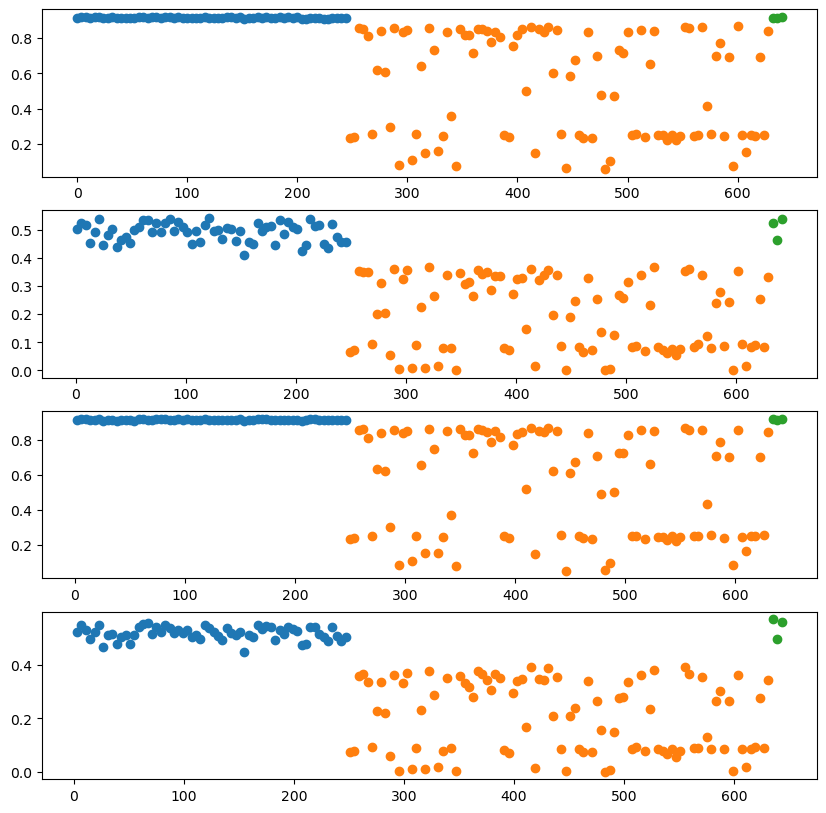

In [99]:
f, axs = plt.subplots(4,1,figsize=(10,10))
j = 0
for i, (archi, data) in enumerate(performance.items()):
    for dps in data:
        for ax, dp in zip(axs, dps[:4]):
            ax.scatter(j, dp, color=plt.cm.tab10(i))
            j += 1

In [105]:
print('Best performers: ')
for k, vs in performance.items():
    print(k, ' : ',[v[-1] for v in sorted(vs, key=lambda x: np.sum(x[:4]))][-1])

Best performers: 
fcnn  :  fcnn_active_composit_batch_0128_mdim_08_128_2
attention  :  attention_mat2vec_batch_0128_mdim_08_256_2
convolution  :  convolution_oliynyk_batch_0128_mdim_08_128_2


In [204]:
mat = {}
dct = {}
for comp, count in counter.items():
    if comp not in label_comp_mapper.keys(): continue
    i = label_comp_mapper[comp]
    s1 = '{:10s} | {:4d} tr | '.format(comp, count[0])
    s2 = '{:10s} | {:4d} v  | '.format('', count[1])
    s3 = '{:10s} | {:4d} te | '.format('', count[2])
    for s, archi, model in zip([s1, s2, s3], ['FC','GA','GC'],
                               ['fcnn_active_composit_batch_0128_mdim_08_128_2',
                                'attention_mat2vec_batch_0128_mdim_08_256_2',
                                'convolution_oliynyk_batch_0128_mdim_08_128_2',]):
        if archi not in mat.keys():
            mat[archi] = {}
            dct[archi] = {}
        s += '{:2s} | '.format(archi)
        for ds in ['valid','test']:
            if ds not in mat[archi].keys():
                mat[archi][ds] = []
                dct[archi][ds] = {}
            m1 = targets[ds] == i
            m2 = predictions[model][ds] == i
            if m1.sum() == 0:
                s += '{:34} | '.format('')
                mat[archi][ds].append([comp, m1.sum(), 0, 0, 0])
                continue
            tp = (m1 & m2).sum()
            tn = (~m1 & ~m2).sum()
            fp = (~m1 & m2).sum()
            fn = (m1 & ~m2).sum()
            prec = tp / (tp + fp) if tp + fp != 0 else 0
            rec = tp / (tp + fn) if tp + fn != 0 else 0
            f1 = 2 * tp / (2 * tp + fp + fn) if tp + fp + fn != 0 else 0
            s += '{:5d}{:5d}{:8.3f}{:8.3f}{:8.3f} | '.format(m1.sum(), m2.sum(), prec * 100, rec * 100, f1 * 100)
            mat[archi][ds].append([comp, m1.sum(), prec, rec, f1])
            dct[archi][ds][comp] = m1.sum(), prec, rec, f1
        print(s)

O-Ti       | 3648 tr | FC |   716  718  99.721 100.000  99.861 |   535  541  98.706  99.813  99.257 | 
           |  720 v  | GA |   716  737  95.115  97.905  96.490 |   535  569  93.322  99.252  96.196 | 
           |  537 te | GC |   716  718  99.721 100.000  99.861 |   535  542  98.708 100.000  99.350 | 
C-O-Sr     | 3565 tr | FC |   540  554  94.946  97.407  96.161 |   365  390  92.564  98.904  95.629 | 
           |  557 v  | GA |   540  604  89.404 100.000  94.406 |   365  398  91.709 100.000  95.675 | 
           |  368 te | GC |   540  585  92.137  99.815  95.822 |   365  394  92.386  99.726  95.916 | 
C-O-Ba     | 3421 tr | FC |   554  587  94.378 100.000  97.108 |   335  357  93.557  99.701  96.532 | 
           |  572 v  | GA |   554  603  91.708  99.819  95.592 |   335  367  91.281 100.000  95.442 | 
           |  341 te | GC |   554  585  94.530  99.819  97.103 |   335  357  93.557  99.701  96.532 | 
O-La       | 3362 tr | FC |   526  555  94.775 100.000  97.317 |   292  3

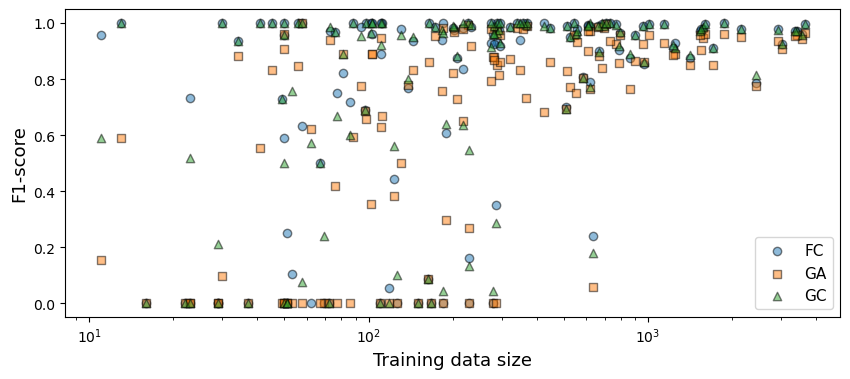

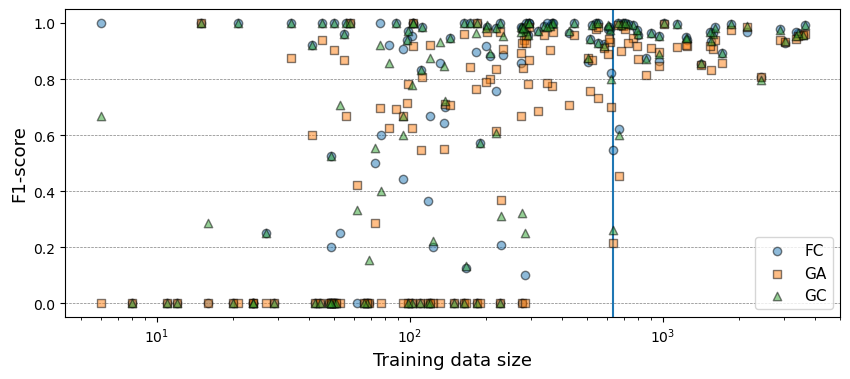

In [232]:
f1, ax1 = plt.subplots(1,1,figsize=(10,4))
f2, ax2 = plt.subplots(1,1,figsize=(10,4))
for i, (archi, data) in enumerate(mat.items()):
    for ax, (ds, dat) in zip([ax1, ax2], data.items()):
        label = np.array(mat[archi][ds]).T[0]
        n_tr, n_v, n_te = np.array([counter[l] for l in label]).T
        if ds == 'valid':
            m = (n_v != 0) & (n_v > 10)
        else:
            m = (n_te != 0) & (n_te > 5)
        true_count, prec, rec, f1 = np.array(mat[archi][ds])[m].T[1:].astype(float)
        ax.scatter(n_tr[m], f1, marker=['o','s','^'][i], color=plt.cm.tab10(i), alpha=0.5, edgecolors=[0,0,0], label=archi, zorder=10)
        ax.set_xscale('log')
        ax.legend(loc='lower right', fontsize=11)
        ax.set_ylabel('F1-score', fontsize=13)
        ax.set_xlabel('Training data size', fontsize=13)
for i in range(5):
    ax2.axhline(i * 0.2, ls='--', color=[0.5, 0.5, 0.5], lw=0.5, zorder=0)
ax2.axvline(634)

In [224]:
m = targets['valid'] == 7
for model in ['fcnn_active_composit_batch_0128_mdim_08_128_2',
              'attention_mat2vec_batch_0128_mdim_08_256_2',
              'convolution_oliynyk_batch_0128_mdim_08_128_2',]:
    m1 = predictions[model]['valid'] == 36
#    print(np.array(target_precursor_comps['valid'])[m & m1])
    print(np.unique(predictions[model]['valid'][m], return_counts=True))
    
label_comp_mapper[36],label_comp_mapper[59],label_comp_mapper[103]

(array([  7,  36,  59, 103]), array([236,  38,   3,   1]))
(array([ 7, 36, 59]), array([251,  10,  17]))
(array([ 7, 36, 59]), array([257,  18,   3]))


('C-O-Mn', 'Mn', 'H-C-O-Mn')

In [211]:
for k1, v1 in dct.items():
    for k2, v2 in v1.items():
        print(k1, k2, '\t', ' '.join([f'{v:.3f}' for v in v2['C-O-Mn'][1:]]), ' '.join([f'{v:.3f}' for v in v2['Mn'][1:]]))

FC valid 	 0.310 0.196 0.240 0.962 0.990 0.976
FC test 	 0.615 0.492 0.547 0.958 0.958 0.958
GA valid 	 0.214 0.033 0.057 0.800 0.832 0.816
GA test 	 0.889 0.123 0.216 0.776 0.792 0.784
GC valid 	 0.367 0.120 0.180 0.962 0.990 0.976
GC test 	 0.579 0.169 0.262 0.958 0.958 0.958


{'None': {'Se_1.00000': 989,
  'S_1.00000': 787,
  'H_0.50000 N_0.08333 O_0.33333 P_0.08333': 587,
  'H_0.56250 N_0.12500 O_0.25000 P_0.06250': 264,
  'P_1.00000': 196,
  'C_1.00000': 131,
  'O_0.71429 P_0.28571': 144,
  'H_0.37500 O_0.50000 P_0.12500': 83,
  'H_0.66667 N_0.16667 Cl_0.16667': 45,
  'P_0.28571 S_0.71429': 17,
  'P_0.28571 Se_0.71429': 10,
  'H_0.66667 N_0.16667 F_0.16667': 29,
  'O_0.66667 Se_0.33333': 25,
  'I_1.00000': 21,
  'H_0.66667 C_0.22222 O_0.11111': 18,
  'H_0.53333 N_0.13333 O_0.26667 S_0.06667': 15,
  'H_0.28571 O_0.57143 S_0.14286': 9,
  'H_0.60000 N_0.15000 O_0.20000 P_0.05000': 9,
  'O_0.80000 P_0.20000': 4,
  'H_0.62500 N_0.12500 F_0.25000': 5,
  'P_0.40000 S_0.60000': 3,
  'H_0.45455 N_0.09091 O_0.36364 P_0.09091': 3,
  'H_0.34615 N_0.07692 O_0.46154 P_0.11538': 3,
  'H_0.27273 N_0.04545 O_0.54545 P_0.13636': 4,
  'H_0.66667 C_0.16667 O_0.16667': 4,
  'H_0.37500 C_0.37500 O_0.25000': 4,
  'H_0.64286 C_0.21429 S_0.07143 I_0.07143': 4,
  'H_0.25000 C_0.25

In [240]:
#f1, ax1 = plt.subplots(1,1,figsize=(10,4))
#f2, ax2 = plt.subplots(1,1,figsize=(10,4))
for i, (archi, data) in enumerate(mat.items()):
    arr = np.array(mat[archi]['valid']).T
    label = arr[0]
    count = np.array([counter[l] for l in label]).T
    true_count, prec, rec, f1 = arr[1:].astype(float)
#    for ax, (ds, dat) in zip([ax1, ax2], data.items()):
#        label = np.array(mat[archi][ds]).T[0]
#        n_tr, n_v, n_te = np.array([counter[l] for l in label]).T
#        if ds == 'valid':
#            m = (n_v != 0) & (n_v > 10)
#        else:
#            m = (n_te != 0) & (n_v > 10)
#        true_count, prec, rec, f1 = np.array(mat[archi][ds])[m].T[1:].astype(float)
#        ax.scatter(n_tr[m], f1, marker=['o','s','^'][i], color=plt.cm.tab10(i), alpha=0.5, edgecolors=[0,0,0], label=archi, zorder=10)
#        ax.set_xscale('log')
#        ax.legend(loc='lower right', fontsize=11)
#        ax.set_ylabel('F1-score', fontsize=13)
#        ax.set_xlabel('Training data size', fontsize=13)
#for i in range(5):
#    ax1.axhline(i * 0.2, ls='--', color=[0.5, 0.5, 0.5], lw=0.5, zorder=0)
#ax1.axvline(634)

In [262]:
for mele in MetalElements:
    m1 = np.array([mele in l.split('-') for l in label])
    m2 = count[1] > 10
    if np.sum(m1 & m2) == 0:
        continue
    print(mele)
    for i in np.where(m1 & m2)[0]:
        print(f'{label[i]:>20s} {count.T[i].sum():5d} {f1[i]*100:7.3f} ')

Li
              Li-C-O  1932  88.789 
              H-Li-O   344  28.571 
                Li-O   102  24.000 
                Li-F    96  66.667 
                  Li    66  50.000 
B
                 B-O   314  63.736 
               H-B-O   280  54.795 
                   B   111 100.000 
Na
              C-O-Na  1814  92.169 
                  Na   163  95.455 
                F-Na    87  50.000 
            H-O-Na-P    75  75.862 
                O-Na    68   0.000 
              O-Na-P    60   0.000 
Mg
                O-Mg  1406  86.213 
                  Mg   429  98.630 
            H-C-O-Mg   235   4.348 
              C-O-Mg   181   0.000 
Al
                O-Al  1845  91.154 
                  Al   702  96.175 
              H-O-Al   194   0.000 
Si
                O-Si  2028  97.340 
                  Si   355  96.104 
                N-Si   224  64.000 
Ca
              C-O-Ca  3802  92.505 
                O-Ca   351   4.255 
                  Ca   114  98.551 
        

In [26]:
from src.feature import feature_to_composit, feature_to_ligand_index, ligand_composit_feature, ligand_label, ligand_index, ligand_vector
from src.utils import find_nearest, squared_error, cosin_similarity
from sklearn.metrics import confusion_matrix

prd = output['conv_active_composit_batch_0256_mdim_16_032_2_case_09']['valid']['pred']
inp = output['conv_active_composit_batch_0256_mdim_16_032_2_case_09']['valid']['input']

inp_lbls = []
prd_lbls = []
for i, p in zip(inp, prd):
    i_i, sser, csim = find_nearest(i.reshape(1,-11), ligand_vector)
    i_p, sser, csim = find_nearest(p.reshape(1,-11), ligand_vector)
    inp_lbls.append(i_i[0])
    prd_lbls.append(i_p[0])
cm = confusion_matrix(inp_lbls, prd_lbls)

In [43]:
for i, (idx, cnt) in enumerate(zip(*np.unique(inp_lbls+prd_lbls, return_counts=True))):
#    print(ligand_index[idx], cnt, cm[i,i] / cm[i].sum(), cm[i,i] / cm[:,i].sum())
    print('{:15s} {:10d} ({:.5f}) {:10d} ({:.5f})'.format(ligand_index[i], cm[i].sum(), cm[i].sum()/len(inp_lbls), cm[:, i].sum(), cm[:, i].sum()/len(inp_lbls)))
#for i in range(79):
#    print('{:15s} {:10.0f} {:8.4f} {:8.4f}'.format(ligand_index[i], cm[i, i], cm[i, i] / cm[i].sum(), cm[i, i] / cm[:, i].sum()))

Metal-O               8486 (0.42915)       9203 (0.46541)
Metal-C-O             2493 (0.12607)       2393 (0.12102)
Metal                 7103 (0.35921)       7803 (0.39461)
Metal-H-O              144 (0.00728)          0 (0.00000)
Metal-N-O               95 (0.00480)          0 (0.00000)
Se                     294 (0.01487)          0 (0.00000)
H-N-O-P                189 (0.00956)        126 (0.00637)
S                      203 (0.01027)          0 (0.00000)
Metal-H-C-O             81 (0.00410)          0 (0.00000)
Metal-F                147 (0.00743)          0 (0.00000)
Metal-S                140 (0.00708)         28 (0.00142)
Metal-N                 36 (0.00182)          0 (0.00000)
Metal-Cl                37 (0.00187)          0 (0.00000)
Metal-H-N-O             53 (0.00268)          0 (0.00000)
Metal-O-P               39 (0.00197)          0 (0.00000)
Metal-H-O-P             32 (0.00162)          0 (0.00000)
P                       33 (0.00167)        110 (0.00556)
Metal-Se      

In [236]:
tol = 0.5
input_index = np.array(feature_to_ligand_index(o['input']))
pred_index = np.array(feature_to_ligand_index(o['pred'], tol=0.5))
input_label = np.array([ligand_index[i] for i in input_index])
pred_label = np.array([ligand_index[i] if i != -1 else 'Fail' for i in pred_index])

In [244]:
import gzip, pickle
with gzip.open('../data/unique_ligand.pkl.gz','rb') as f:
    unique_ligand = pickle.load(f)
unique_ligand

{('O',): {'count': 86539,
  'metals': {('Y',): {'count': 3101,
    'case': [{'composition': {'Y': 0.4, 'O': 0.6},
      'years': [1979,
       1979,
       1986,
       1995,
       1995,
       1996,
       1996,
       1996,
       1996,
       1997,
       1997,
       1997,
       1997,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       2000,
       2000,
       2000,
       2000,
       2000,
       2000,
       2000,
      

In [102]:
ligands = {}
precursors = {}
for ligand, _ligand_data in unique_ligand.items():
    for metal, _metal_data in _ligand_data['metals'].items():
        precursor = metal, ligand
        c = _metal_data['count']
        if len(metal) == 0:
            if precursor not in ligands.keys():
                ligands[precursor] = 0
                precursors[precursor] = 0
            ligands[precursor] += c
            precursors[precursor] += c
        else:
            if precursor not in precursors.keys():
                precursors[precursor] = 0
            if (('Metal',), ligand) not in ligands.keys():
                ligands[(('Metal',), ligand)] = 0
            ligands[(('Metal',), ligand)] += c
            precursors[precursor] += c
ligands = {k:v for k,v in sorted(ligands.items(), key=lambda x: x[1], reverse=True)}
precursors = {k:v for k,v in sorted(precursors.items(), key=lambda x: x[1], reverse=True)}
ligands.update({((),()):0})

precursors.update({((),()):0})


In [107]:
from src.feature import active_composit_feature, ligand_composit_feature

ligand_vector = np.vstack([ligand_composit_feature({e if e != 'Metal' else 'Li':1 for e in k[0] + k[1]}, dtype=float) for k in ligands.keys()])
precursor_vector = np.vstack([active_composit_feature({e:1 for e in k[0] + k[1]}, dtype=float) for k in precursors.keys()])

def parse_feature(feat_vec, csim_cut = 0.5, sser_cut = 1.0, to_string=False):
    out = []
    if feat_vec.shape[-1] == 12:
        ref = ligand_vector
        chrs = np.array(['-'.join(k[0] + k[1]) for k in ligands.keys()] + ['Unknown'])
    elif feat_vec.shape[-1] == 97:
        ref = precursor_vector
        chrs = np.array(['-'.join(k[0] + k[1]) for k in precursors.keys()] + ['Unknown'])
    else:
        raise ValueError('Not supported feature type')

    for idx, sser, csim in zip(*find_nearest(feat_vec, ref)):
        if (sser > sser_cut) or (csim < csim_cut):
            out.append(-1)
        else:
            out.append(int(idx))
    if to_string:
        return chrs[out]
    else:
        return out
    

_inp_lbls = parse_feature(inp)
_prd_lbls = parse_feature(prd)

In [36]:
pred_index[4554], input_index[4554]

(0, 0)

In [49]:
for i_inp in sorted(np.unique(input_index), key=lambda x: ligand_index[x]):
    m = input_index == i_inp
    a = np.sum(pred_index[m] == i_inp)
    t = np.sum(m)
    print('{:15s} {:5d} {:5d} {:8.3f}'.format(ligand_index[i_inp], t, a, 100*a/t))
    
#    print(sorted(zip(*np.unique(np.array(pred_label)[m], return_counts=True)), key=lambda x: x[1], reverse=True))

C                   7     7  100.000
H-C-N-O             2     0    0.000
H-C-O               6     0    0.000
H-C-S-Br            3     0    0.000
H-C-S-Cl            3     0    0.000
H-C-S-I             4     0    0.000
H-N-Cl             19    12   63.158
H-N-F               2     0    0.000
H-N-O-P            18    18  100.000
H-N-O-S             5     0    0.000
H-O-P               8     0    0.000
Metal            1518  1466   96.574
Metal-Br           10     2   20.000
Metal-C             4     0    0.000
Metal-C-O        1572  1448   92.112
Metal-C-S           1     0    0.000
Metal-Cl           23     5   21.739
Metal-F            36    14   38.889
Metal-H-C-N-Br      1     0    0.000
Metal-H-C-N-Cl      1     0    0.000
Metal-H-C-N-I       1     0    0.000
Metal-H-C-O        90     0    0.000
Metal-H-F           1     0    0.000
Metal-H-N-O        28     3   10.714
Metal-H-O          97    15   15.464
Metal-H-O-P        10     0    0.000
Metal-H-O-S         2     0    0.000
M

In [66]:
import run_fcvae_class as R

#R.parser.parse_args('--logging')
#R.args
#R.logging = True
#R.epochs = 5
#R.main(R.args)

usage: ipykernel_launcher.py [-h] [--hidden_dim HIDDEN_DIM]
                             [--hidden_layers HIDDEN_LAYERS]
                             [--latent_dim LATENT_DIM]
                             [--batch_size BATCH_SIZE] [--epochs EPOCHS]
                             [--early_stop EARLY_STOP]
                             [--logging_interval LOGGING_INTERVAL]
                             [--target_feature_type TARGET_FEATURE_TYPE]
                             [--logging]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/jhyang/.local/share/jupyter/runtime/kernel-v2-245045jJs10vwAO5mJ.json


SystemExit: 2

In [19]:
predictions = {}
for task in ['reg','cls']:
    for model in os.listdir(os.path.join(root_t, task)):
        model_type = model.split('_')[0]
#        print(model_type)
print(os.listdir(os.path.join(root_t, task, model)))
with open(os.path.join(root_t, task, model, 'output.valid.pkl'), 'rb') as f:
    out = pickle.load(f)
#out['label']
#out['input'].shape   

['model_decoder.model', 'epoch.txt', 'events.out.tfevents.1714524199.jhyangw22.2655570.38', 'output.test.pkl', 'model_encoder.model', 'output.valid.pkl']


array([{'Zn': 0.11111111, 'N': 0.22222222, 'O': 0.6666667},
       {'Fe': 0.11111111, 'N': 0.22222222, 'O': 0.6666667},
       {'Pb': 0.4, 'O': 0.6}, ..., {'Cr': 0.4, 'O': 0.6}, {'Al': 1.0},
       {'Mg': 1.0}], dtype=object)

In [45]:
precursors = np.hstack([info['precursor_comp'] for info in out['info']])
fracs = []
for i in range(np.max(out['label'])+1):
    comp, count = np.unique([str(p) for p in precursors[out['label'] == i]], return_counts=True)
    frac = count / np.sum(count)
    fracs.append((sorted(frac, reverse=True), np.sum(count)))
